In [1]:
import pandas as pd 
from selenium import webdriver
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import re
import string
import math

In [2]:
n_future = 1
n_past = 5

In [3]:
full_WP = pd.read_csv("./Full WP dataset.csv")

C:\Users\Louis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (1,2,8,9,14,25,131,132,133,161,162) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data Preprcoessing

In [4]:
full_WP = full_WP.iloc[1:]

In [5]:
full_WP = full_WP.loc[full_WP['SEASON'].astype(int) >= 2000]

In [6]:
columns_features = ['ISO_TIME', 'SEASON', 'NAME', 'USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']

In [7]:
full_WP_modify = full_WP[columns_features].copy()

In [8]:
full_WP_modify

,ISO_TIME,SEASON,NAME,USA_LAT,USA_LON,DIST2LAND,USA_WIND,USA_PRES,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW
196947,2000-05-03 18:00:00,2000,DAMREY,6.20000,135.700,773,25,,,,,,,,,,,,,
196948,2000-05-03 21:00:00,2000,DAMREY,6.77253,135.535,840,25,,,,,,,,,,,,,
196949,2000-05-04 00:00:00,2000,DAMREY,7.30000,135.400,896,25,,,,,,,,,,,,,
196950,2000-05-04 03:00:00,2000,DAMREY,7.74498,135.320,935,25,,,,,,,,,,,,,
196951,2000-05-04 06:00:00,2000,DAMREY,8.10000,135.300,960,25,,,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239452,2021-09-23 00:00:00,2021,NOT_NAMED,13.5000,111.200,196,29,1003,,,,,,,,,,,,
239453,2021-09-23 03:00:00,2021,NOT_NAMED,13.8697,110.707,151,32,1003,,,,,,,,,,,,
239454,2021-09-23 06:00:00,2021,NOT_NAMED,14.3000,110.200,106,35,1003,90,,,50,,,,,,,,
239455,2021-09-23 09:00:00,2021,NOT_NAMED,14.7481,109.586,53,35,1002,60,,,40,,,,,,,,


In [9]:
full_WP_modify = full_WP_modify.reset_index(drop=True)

In [10]:
full_WP_modify = full_WP_modify[full_WP_modify.NAME != 'NOT_NAMED']

In [11]:
full_WP_modify = full_WP_modify.reset_index(drop=True)

In [12]:
full_WP_modify = full_WP_modify[full_WP_modify.USA_LAT!=' ']

In [13]:
full_WP_modify = full_WP_modify.replace(r'^\s*$', -1 , regex=True)

In [14]:
full_WP_modify['USA_LAT'] = full_WP_modify['USA_LAT'].astype(float)

In [15]:
full_WP_modify['USA_LON'] = full_WP_modify['USA_LON'].astype(float)

In [16]:
full_WP_modify['USA_LAT'].min()

1.3

In [17]:
full_WP_modify['USA_LAT'].max()

51.3

In [18]:
full_WP_modify['USA_LON'].min()

-180.0

In [19]:
full_WP_modify['USA_LON'].max()

180.0

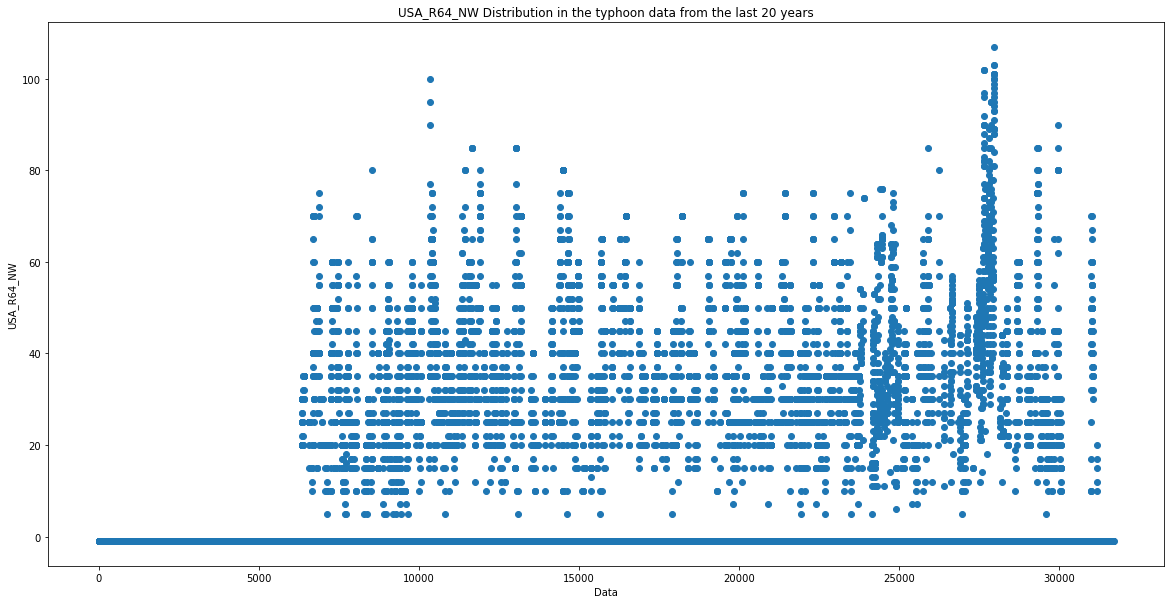

In [20]:
full_WP_modify['USA_R64_NW'] = full_WP_modify['USA_R64_NW'].astype(float)
# full_WP_modify = full_WP_modify.drop(full_WP_modify[full_WP_modify.USA_PRES < 100].index)
pressure_list = full_WP_modify['USA_R64_NW'].astype(float).tolist()
axis_pressure = np.arange(len(full_WP_modify['USA_R64_NW'])) 
plt.figure(figsize=(20, 10))
plt.scatter(axis_pressure, pressure_list)
plt.title("USA_R64_NW Distribution in the typhoon data from the last 20 years")
plt.xlabel("Data")
plt.ylabel("USA_R64_NW")
plt.savefig("USA_R64_NW distribution")
plt.show()

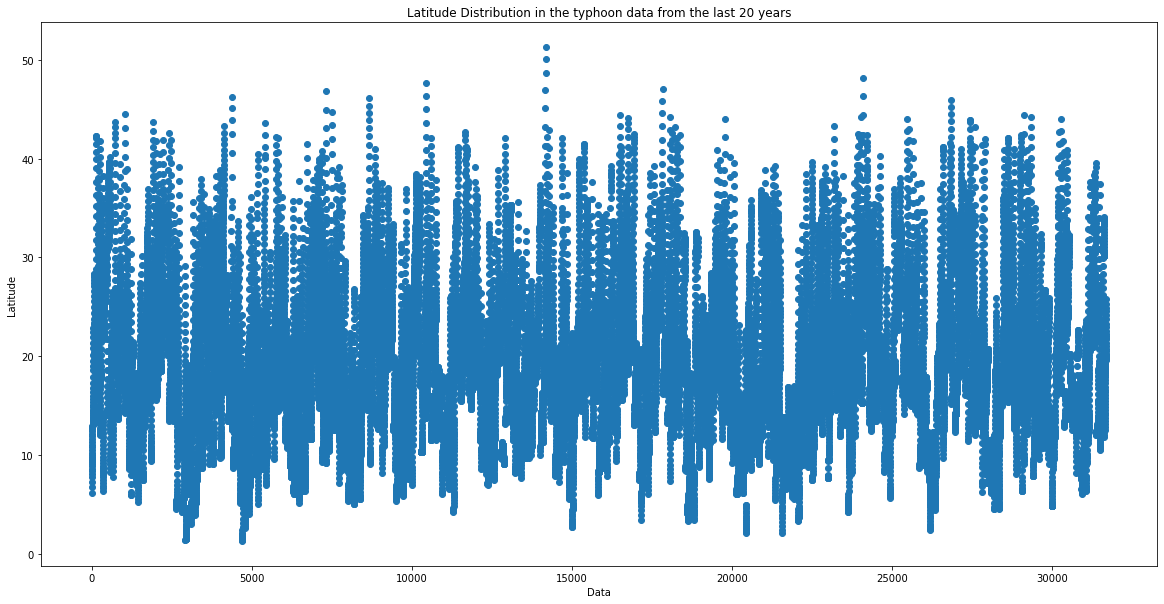

In [21]:
lat_list = full_WP_modify['USA_LAT'].tolist()
axis_lat = np.arange(len(full_WP_modify['USA_LAT'])) 
plt.figure(figsize=(20, 10))
plt.scatter(axis_lat, lat_list)
plt.title("Latitude Distribution in the typhoon data from the last 20 years")
plt.xlabel("Data")
plt.ylabel("Latitude")
plt.savefig("latitude distribution")
plt.show()

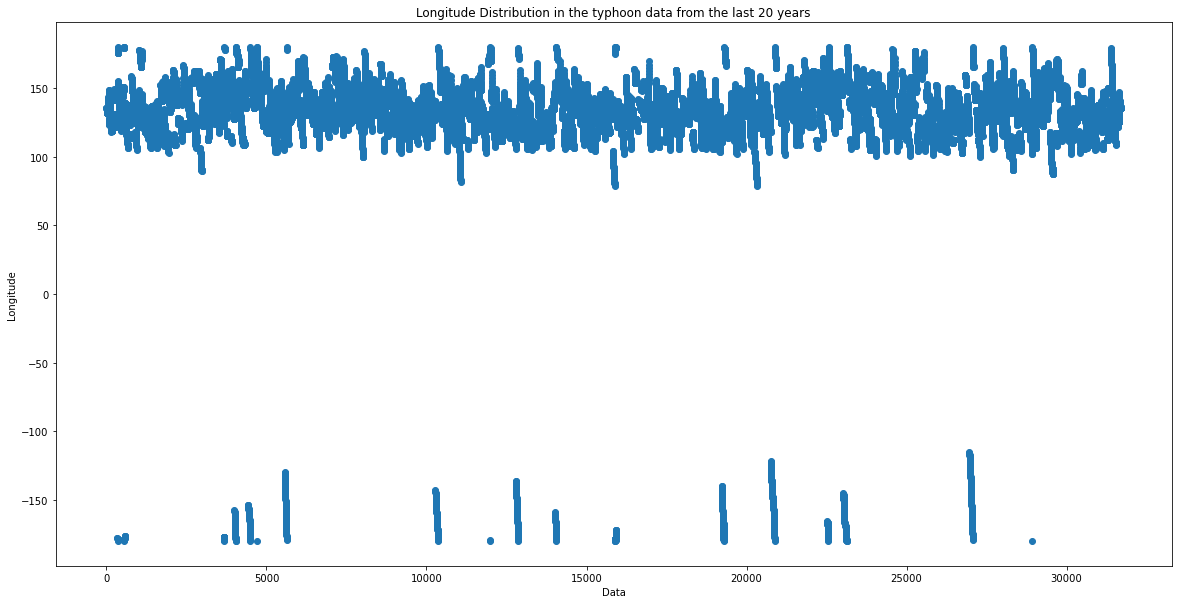

In [22]:
long_list = full_WP_modify['USA_LON'].tolist()
axis_lon = np.arange(len(full_WP_modify['USA_LON'])) 
plt.figure(figsize=(20, 10))
plt.scatter(axis_lon, long_list)
plt.title("Longitude Distribution in the typhoon data from the last 20 years")
plt.xlabel("Data")
plt.ylabel("Longitude")
plt.savefig("Longitude distribution")
plt.show()

In [23]:
full_WP_modify = full_WP_modify.reset_index(drop=True)

In [24]:
full_WP_modify['USA_LAT'].min()

1.3

In [25]:
full_WP_modify['USA_LAT'].max()

51.3

In [26]:
full_WP_modify['USA_LON'].min()

-180.0

In [27]:
full_WP_modify['USA_LON'].max()

180.0

In [28]:
# full_WP_modify = full_WP_modify.drop(full_WP_modify[full_WP_modify.USA_LON < 0].index)

In [29]:
full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] = full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] + 360

C:\Users\Louis\AppData\Local\Temp/ipykernel_20176/916726116.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] = full_WP_modify['USA_LON'][full_WP_modify[full_WP_modify.USA_LON < 0].index] + 360


In [30]:
full_WP_modify['USA_LON'].max()

244.9

In [31]:
full_WP_modify['USA_LON'].min()

78.6

In [32]:
long_range = full_WP_modify.index[full_WP_modify['USA_LON'] <0].tolist()

In [33]:
len(long_range)

0

In [34]:
full_WP_modify

,ISO_TIME,SEASON,NAME,USA_LAT,USA_LON,DIST2LAND,USA_WIND,USA_PRES,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW
0,2000-05-03 18:00:00,2000,DAMREY,6.20000,135.700,773,25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0
1,2000-05-03 21:00:00,2000,DAMREY,6.77253,135.535,840,25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0
2,2000-05-04 00:00:00,2000,DAMREY,7.30000,135.400,896,25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0
3,2000-05-04 03:00:00,2000,DAMREY,7.74498,135.320,935,25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0
4,2000-05-04 06:00:00,2000,DAMREY,8.10000,135.300,960,25,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31694,2021-09-29 06:00:00,2021,MINDULLE,24.20000,135.400,888,115,933,235,240,180,215,-1,-1,-1,-1,-1,-1,-1,-1.0
31695,2021-09-29 09:00:00,2021,MINDULLE,24.55000,135.420,860,115,933,242,262,190,222,-1,-1,-1,-1,-1,-1,-1,-1.0
31696,2021-09-29 12:00:00,2021,MINDULLE,24.90000,135.500,827,115,933,250,285,200,230,-1,-1,-1,-1,-1,-1,-1,-1.0
31697,2021-09-29 15:00:00,2021,MINDULLE,25.32510,135.672,800,112,934,250,285,200,230,-1,-1,-1,-1,-1,-1,-1,-1.0


In [35]:
dict_remove = {}
for i in long_range:
    print(i)
    name = full_WP_modify.iloc[i,2]
    year = full_WP_modify.iloc[i,1]
    dict_remove[year] = name

In [36]:
dict_remove

{}

In [37]:
from sklearn.preprocessing import MinMaxScaler

scaler_lat = MinMaxScaler()
scaler_long = MinMaxScaler()
scaler_dist = MinMaxScaler()
scaler_wind = MinMaxScaler()
scaler_pres = MinMaxScaler()
scaler_r34_ne = MinMaxScaler()
scaler_r34_se = MinMaxScaler()
scaler_r34_sw = MinMaxScaler()
scaler_r34_nw = MinMaxScaler()
scaler_r50_ne = MinMaxScaler()
scaler_r50_se = MinMaxScaler()
scaler_r50_sw = MinMaxScaler()
scaler_r50_nw = MinMaxScaler()
scaler_r64_ne = MinMaxScaler()
scaler_r64_se = MinMaxScaler()
scaler_r64_sw = MinMaxScaler()
scaler_r64_nw = MinMaxScaler()

In [38]:
full_WP_modify[['USA_LAT']] = scaler_lat.fit_transform(full_WP_modify[['USA_LAT']])
full_WP_modify[['USA_LON']] = scaler_long.fit_transform(full_WP_modify[['USA_LON']])
full_WP_modify[['DIST2LAND']] = scaler_dist.fit_transform(full_WP_modify[['DIST2LAND']])
full_WP_modify[['USA_WIND']] = scaler_wind.fit_transform(full_WP_modify[['USA_WIND']])
full_WP_modify[['USA_PRES']] = scaler_pres.fit_transform(full_WP_modify[['USA_PRES']])
full_WP_modify[['USA_R34_NE']] = scaler_r34_ne.fit_transform(full_WP_modify[['USA_R34_NE']])
full_WP_modify[['USA_R34_SE']] = scaler_r34_se.fit_transform(full_WP_modify[['USA_R34_SE']])
full_WP_modify[['USA_R34_SW']] = scaler_r34_sw.fit_transform(full_WP_modify[['USA_R34_SW']])
full_WP_modify[['USA_R34_NW']] = scaler_r34_nw.fit_transform(full_WP_modify[['USA_R34_NW']])
full_WP_modify[['USA_R50_NE']] = scaler_r50_ne.fit_transform(full_WP_modify[['USA_R50_NE']])
full_WP_modify[['USA_R50_SE']] = scaler_r50_se.fit_transform(full_WP_modify[['USA_R50_SE']])
full_WP_modify[['USA_R50_SW']] = scaler_r50_sw.fit_transform(full_WP_modify[['USA_R50_SW']])
full_WP_modify[['USA_R50_NW']] = scaler_r50_nw.fit_transform(full_WP_modify[['USA_R50_NW']])
full_WP_modify[['USA_R64_NE']] = scaler_r64_ne.fit_transform(full_WP_modify[['USA_R64_NE']])
full_WP_modify[['USA_R64_SE']] = scaler_r64_se.fit_transform(full_WP_modify[['USA_R64_SE']])
full_WP_modify[['USA_R64_SW']] = scaler_r64_sw.fit_transform(full_WP_modify[['USA_R64_SW']])
full_WP_modify[['USA_R64_NW']] = scaler_r64_nw.fit_transform(full_WP_modify[['USA_R64_NW']])

In [39]:
full_WP_modify['USA_LAT'].min()

0.0

In [40]:
full_WP_modify['USA_LAT'].max()

1.0

In [41]:
full_WP_modify['USA_LAT'].min()

0.0

In [42]:
full_WP_modify['USA_LON'].max()

0.9999999999999999

In [43]:
lat_list = full_WP_modify['USA_LAT'].tolist()

In [44]:
axis_lat = np.arange(len(full_WP_modify['USA_LAT'])) 

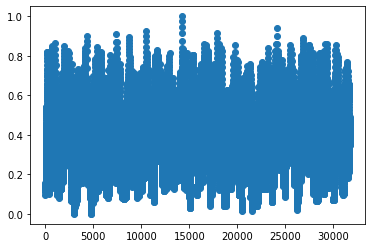

In [45]:
plt.scatter(axis_lat, lat_list)

In [46]:
long_list = full_WP_modify['USA_LON'].tolist()

In [47]:
axis_lon = np.arange(len(full_WP_modify['USA_LON'])) 

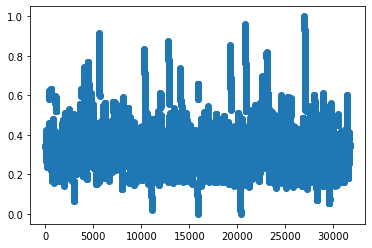

In [48]:
plt.scatter(axis_lon, long_list)

In [49]:
for year in range(2000,2022):
     globals()['df_WP_%s' % year] = full_WP_modify[(full_WP_modify["SEASON"]==year)]

In [50]:
for year in range(2000,2022):
    globals()['df_WP_%s' % year] = globals()['df_WP_%s' % year].reset_index(drop=True)

In [51]:
for year in range(2000,2022):
    globals()['df_WP_%s' % year] =  globals()['df_WP_%s' % year].drop(['SEASON'], axis=1)

In [52]:
for year in range(2000,2022):
    for i in range(len(globals()['df_WP_%s' % year])):
        globals()['df_WP_%s' % year].iloc[i,1] = re.sub(r"[^\w\s]", '',  globals()['df_WP_%s' % year].iloc[i,1])

In [53]:
summarylist = []
for year in range(2000,2022):
    summarylist.append(dict(tuple(globals()['df_WP_%s' % year].groupby('NAME'))))

In [54]:
tc_name_list = []
for i in range(len(summarylist)):
    tc_name_list.append(list(summarylist[i].keys()))

In [55]:
print(tc_name_list[0])

['BEBINCA', 'BILIS', 'BOLAVEN', 'BOPHA', 'CHANCHU', 'DAMREY', 'EWINIAR', 'JELAWAT', 'KAEMI', 'KAITAK', 'KIROGI', 'LONGWANG', 'MARIA', 'PRAPIROON', 'RUMBIA', 'SAOMAI', 'SHANSHAN', 'SONAMU', 'SOULIK', 'TEMBIN', 'WENE', 'WUKONG', 'XANGSANE', 'YAGI']


In [56]:
count = 0
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        count = count+1
        globals()['df_WP_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s' % (str(2000+i))][globals()['df_WP_%s' % (str(2000+i))].NAME == name]
#         globals()['df_WP_%s_%s'%((str(2000+i)), name)]  = globals()['df_WP_%s_%s'%((str(2000+i)), name)][globals()['df_WP_%s_%s'%((str(2000+i)),name)].USA_LAT != ' ']
        globals()['df_WP_%s_%s'%((str(2000+i)), name)]  = globals()['df_WP_%s_%s'%((str(2000+i)), name)] .reset_index(drop=True)

In [57]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_WP_%s_%s'%((str(2000+i)), name)] = (globals()['df_WP_%s_%s'%((str(2000+i)), name)]).drop(['NAME'], axis=1)

In [58]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_WP_%s_%s'%((str(2000+i)), name)].rename(columns={'ISO_TIME':'Date'}, inplace=True)
        globals()['df_WP_%s_%s'%((str(2000+i)), name)]['Date'] = pd.to_datetime(globals()['df_WP_%s_%s'%((str(2000+i)), name)]['Date'], dayfirst=True)

In [59]:
cols_features = list(df_WP_2018_MANGKHUT)[1:len(df_WP_2018_MANGKHUT.columns)]
print(cols_features)

['USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']


In [60]:
df_WP_2018_MANGKHUT

,Date,USA_LAT,USA_LON,DIST2LAND,USA_WIND,USA_PRES,USA_R34_NE,USA_R34_SE,USA_R34_SW,USA_R34_NW,USA_R50_NE,USA_R50_SE,USA_R50_SW,USA_R50_NW,USA_R64_NE,USA_R64_SE,USA_R64_SW,USA_R64_NW
0,2018-09-06 18:00:00,0.214000,0.545400,0.776274,0.122807,0.993103,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2018-09-06 21:00:00,0.216104,0.541569,0.768722,0.122807,0.993103,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2018-09-07 00:00:00,0.218000,0.537583,0.763688,0.122807,0.993103,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2018-09-07 03:00:00,0.219698,0.533373,0.755821,0.134503,0.991133,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2018-09-07 06:00:00,0.222000,0.529164,0.748899,0.152047,0.990148,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2018-09-17 00:00:00,0.434000,0.179796,0.000000,0.239766,0.975369,0.354839,0.280742,0.175705,0.271300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,2018-09-17 03:00:00,0.438446,0.175075,0.000000,0.210526,0.976355,0.178886,0.141531,0.088937,0.136771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,2018-09-17 06:00:00,0.442000,0.170174,0.000000,0.181287,0.978325,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,2018-09-17 09:00:00,0.445114,0.165334,0.000000,0.152047,0.982266,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Latitude Prediction

In [61]:
tc_name_list[18].remove('MANGKHUT')

In [62]:
tc_name_list[18].remove('KONGREY')

In [63]:
tc_name_list[18].remove('YUTU')

In [64]:
tc_name_list[19].remove('WUTIP')

In [65]:
cols_target = list(df_WP_2018_MANGKHUT)[1:2]

In [66]:
cols_target

['USA_LAT']

In [67]:
print(cols_features)
print(cols_target)

['USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']
['USA_LAT']


In [68]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_features_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_features].astype(float)
        globals()['df_target_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_target].astype(float)

In [69]:
trainX_lat = []
trainY_lat = []
valX_lat = []
valY_lat = []
testX_lat = []
testY_lat = []

In [70]:
for i in range(len(tc_name_list)): ### 20 years of data for training (2000-2020)
    for name in tc_name_list[i]:
        globals()['df_features_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_features_lat_%s_%s'%((str(2000+i)), name)].to_numpy()
        globals()['df_target_lat_%s_%s'%((str(2000+i)), name)] = globals()['df_target_lat_%s_%s'%((str(2000+i)), name)].to_numpy()

In [71]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
            for j in range(n_past, len(globals()['df_features_lat_%s_%s'%((str(2000+i)), name)])-n_future+1):
                trainX_lat.append(globals()['df_features_lat_%s_%s'%((str(2000+i)), name)][j-n_past:j,0:globals()['df_features_lat_%s_%s'%((str(2000+i)), name)].shape[1]])
                trainY_lat.append(globals()['df_target_lat_%s_%s'%((str(2000+i)), name)][j+n_future-1:j+n_future,0])

In [72]:
trainX_lat = np.array(trainX_lat)

In [73]:
trainX_lat, trainY_lat= np.array(trainX_lat), np.array(trainY_lat)
valX_lat, valY_lat= np.array(valX_lat), np.array(valY_lat)
testX_lat, testY_lat= np.array(testX_lat), np.array(testY_lat)

# shuffle_idx
# import random
# shuffle_idx= random.shuffle([i for i in range(10000)])
# trainX = trainX[shuffle_idx]
# trainY = trainY[shuffle_idx]

In [74]:
print(trainX_lat.shape)
print(trainY_lat.shape)
print(valX_lat.shape)
print(valY_lat.shape)
print(testX_lat.shape)
print(testY_lat.shape)

(28712, 5, 17)
(28712, 1)
(0,)
(0,)
(0,)
(0,)


In [75]:
trainX_lat, valX_lat = trainX_lat[:(int(len(trainX_lat) * 0.8)),:,:], trainX_lat[(int(len(trainX_lat) * 0.8)):,:,:]

In [76]:
trainY_lat, valY_lat = trainY_lat[:(int(len(trainY_lat) * 0.8)),:], trainY_lat[(int(len(trainY_lat) * 0.8)):,:]

In [77]:
valX_lat, testX_lat = valX_lat[:(int(len(valX_lat) * 0.5)),:,:], valX_lat[(int(len(valX_lat) * 0.5)):,:,:]

In [78]:
valY_lat, testY_lat = valY_lat[:(int(len(valY_lat) * 0.5)),:], valY_lat[(int(len(valY_lat) * 0.5)):,:]

In [79]:
print(trainX_lat.shape)
print(trainY_lat.shape)
print(valX_lat.shape)
print(valY_lat.shape)
print(testX_lat.shape)
print(testY_lat.shape)

(22969, 5, 17)
(22969, 1)
(2871, 5, 17)
(2871, 1)
(2872, 5, 17)
(2872, 1)


In [80]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim

import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [81]:
trainX_lat = torch.from_numpy(trainX_lat).float().to(device)
trainY_lat = torch.from_numpy(trainY_lat).float().to(device)
valX_lat = torch.from_numpy(valX_lat).float().to(device)
valY_lat = torch.from_numpy(valY_lat).float().to(device)
testX_lat = torch.from_numpy(testX_lat).float().to(device)
testY_lat = torch.from_numpy(testY_lat).float().to(device)

In [82]:
from torch.utils.data import TensorDataset, DataLoader

train = TensorDataset(trainX_lat, trainY_lat)
val = TensorDataset(valX_lat, valY_lat)
test = TensorDataset(testX_lat, testY_lat)

# # shuffle = true
# train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, drop_last=True)
# val_loader = DataLoader(val, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader_one = DataLoader(test, batch_size=1, shuffle=True, drop_last=True)

In [83]:
import torch.autograd as autograd

In [84]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, n_past):
        super(LSTMModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.n_past = n_past

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.hidden = self.init_hidden()
    
    def init_hidden(self):
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim),requires_grad=True),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim),requires_grad=True))

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
                
        #out = out.reshape(out.size(0), -1)
                
        out = out[:, -1, :]
        
        # print(out.shape)
        
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        
        # print(out.shape)
        
        # log_probs = F.log_softmax(out)

        return out

In [90]:
validation_list_lat = []

In [91]:
class Optimization_Lat:
    def __init__(self, model, loss_fn, optimizer, max_lat, min_lat, nbins):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.max_lat = max_lat
        self.min_lat = min_lat
        self.nbins = nbins
        # self.criterion = nn.CrossEntropyLoss()

    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()
        
        # self.model.hidden = self.model.init_hidden()
        
        x = x.to(device)
        
        # Makes predictions
        yhat = self.model(x)
        
        y=y[:,0]
        
        
        y=y.type(torch.LongTensor)
        
        y = y.to(device)
        
        #print("Ground Truth: ", y)
        
        #print("Raw predictions: ", yhat)
                
        # yhat = torch.max(yhat.data, 1)
        
        # print("Max predictions: ", yhat)
        
        # yhat = yhat[0]
        
        # print("Max predictions [0] : ", yhat)
                
        # yhat = torch.tensor(yhat).unsqueeze(1)
        
        loss = self.loss_fn(yhat, y)
        
        # print("training loss: " , loss)
        
        # print("Loss: ", loss)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        
        self.optimizer.zero_grad()
       
        # Returns the loss
        return loss.item()
    
    def label_conversion(self, y_batch):
        
        for i in range(len(y_batch)):
            with torch.no_grad():
                y_batch[i] = float(y_batch[i])
                y_batch[i] = int(math.ceil(y_batch[i] / ((self.max_lat-self.min_lat)/self.nbins)))
        return y_batch
    
    def train(self, train_loader, val_loader, batch_size, n_epochs, n_features):
        # model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        
        model_path = "model_lat"
        previous_validation_loss = 100
        patience = 4
        count = 0
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, n_past, n_features])
                
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                x_batch = autograd.Variable(x_batch,requires_grad=True)
                y_batch = autograd.Variable(y_batch,requires_grad=True) 
                
                y_batch= self.label_conversion(y_batch)  

                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, n_past , n_features])
                    
                    x_val = autograd.Variable(x_val,requires_grad=True)
                    y_val = autograd.Variable(y_val,requires_grad=True)  
                    
                    y_val= self.label_conversion(y_val)  

                    # self.model.hidden = self.model.init_hidden()
                    
                    x_val = x_val.to(device)
           
                    self.model.eval()
                    yhat_val = self.model(x_val)
                
                    y_val=y_val[:,0]
        
                    y_val=y_val.type(torch.LongTensor)
        
                    y_val = y_val.to(device)
                
                    #print("yval: " , y_val)
                    
                    #print("yval_hat: " ,yhat_val)

                    # yhat= self.label_conversion(yhat)  

                    val_loss = self.loss_fn(yhat_val, y_val).item()
                    
                    # print("validation loss: " , val_loss)
                    
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                print("Training loss: ", training_loss)
                print("Validation loss: ", validation_loss)
                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.8f}\t Validation loss: {validation_loss:.8f}")
                validation_list_lat.append(validation_loss)
                validation_list_lat.sort()
                if validation_loss <= validation_list_lat[0]:
                    torch.save(self.model, model_path)
                    print("Updated best model")
                if validation_loss > previous_validation_loss:
                    count +=1
                    print("Current Validation_loss is greater than Previous Validation Loss, counting:", count)
                    if count>=patience:
                        print("Early stopping executed!")
                        break
                else:
                    print("Continue progress to global minima")
                    count = 0
                previous_validation_loss = validation_loss 

        # torch.save(self.model.state_dict(), model_path)
    
#     def evaluate(self, test_loader, batch_size=1, n_features=1):
#         with torch.no_grad():
#             predictions = []
#             values = []
#             for x_test, y_test in test_loader:
#                 x_test = x_test.view([batch_size, 5, n_features])
#                 y_test = y_test
#                 self.model.eval()
#                 yhat = self.model(x_test)
#                 predictions.append(yhat.detach().numpy())
#                 values.append(y_test.detach().numpy())

#         return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [92]:
def get_model(model, model_params):
    models = {"lstm": LSTMModel}
    return models.get(model.lower())(**model_params)

Batch:  16    Hidden dim:  16   Learning rate:  0.01
Training loss:  5.385486372173456
Validation loss:  4.77685705376737
[1/100] Training loss: 5.38548637	 Validation loss: 4.77685705
Updated best model
Continue progress to global minima
Training loss:  4.552245457413305
Validation loss:  4.5583836486219695
[2/100] Training loss: 4.55224546	 Validation loss: 4.55838365
Updated best model
Continue progress to global minima
Training loss:  4.357737416922007
Validation loss:  4.3528367487411925
[3/100] Training loss: 4.35773742	 Validation loss: 4.35283675
Updated best model
Continue progress to global minima
Training loss:  4.199629961239752
Validation loss:  4.281576023421474
[4/100] Training loss: 4.19962996	 Validation loss: 4.28157602
Updated best model
Continue progress to global minima
Training loss:  4.061945887475894
Validation loss:  4.150624309838151
[5/100] Training loss: 4.06194589	 Validation loss: 4.15062431
Updated best model
Continue progress to global minima
Training lo

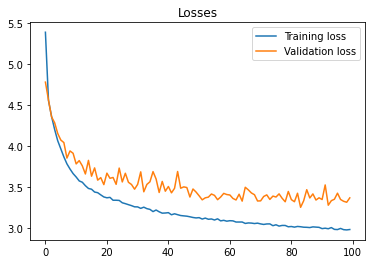

In [93]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# batch_size = 16
nbins = 1000
input_dim = trainX_lat.shape[2]
output_dim = 1001
layer_dim = 1
dropout = 0
n_epochs = 100
# learning_rate = 1e-4
weight_decay = 1e-6
max_lat = 1
min_lat = 0


train = TensorDataset(trainX_lat, trainY_lat)
val = TensorDataset(valX_lat, valY_lat)
test = TensorDataset(testX_lat, testY_lat)

batch_size = [16]
hidden_dim = [16]
learning_rate = [0.01]
    
for batch in batch_size:
    for hd in hidden_dim:
        for lr in learning_rate:
            print("Batch: ", batch, " ", " Hidden dim: ", hd, " ", "Learning rate: ", lr)
            # shuffle = true
            train_loader = DataLoader(train, batch_size=batch, shuffle=True, drop_last=True)
            val_loader = DataLoader(val, batch_size=batch, shuffle=True, drop_last=True)
            test_loader = DataLoader(test, batch_size=batch, shuffle=True, drop_last=True)

            model_params = {'input_dim': input_dim,
                            'hidden_dim' : hd,
                            'layer_dim' : layer_dim,
                            'output_dim' : output_dim,
                            'dropout_prob' : dropout ,
                            'n_past': n_past}

            model = get_model('lstm', model_params).to(device)
            loss_func = nn.CrossEntropyLoss()   
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

            opt_lat = Optimization_Lat(model=model.to(device), loss_fn=loss_func, optimizer=optimizer, max_lat=max_lat , min_lat=min_lat , nbins=nbins)
            opt_lat.train(train_loader, val_loader, batch, n_epochs, input_dim)
            opt_lat.plot_losses()

# predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [94]:
model_lat = torch.load('model_lat')

In [95]:
y_pred_lat = model_lat(testX_lat)

In [96]:
y_pred_lat = y_pred_lat.cpu().detach().numpy()

In [97]:
testY_lat = testY_lat.cpu().detach().numpy()

In [98]:
test_trial = testY_lat.copy()

In [99]:
for i in range(len(test_trial)):
    test_trial[i] = int(math.ceil(test_trial[i] / (1/1000)))

In [100]:
y_pred_lat_trial = y_pred_lat.copy()

In [101]:
pred_conversion = []
for i in range(len(y_pred_lat_trial)):
    pred_conversion.append(np.argmax(y_pred_lat_trial[i]))

In [102]:
pred_array = np.array(pred_conversion)

In [103]:
pred_array = pred_array[:,None]

In [104]:
pred_array.shape

(2872, 1)

In [105]:
result = []
for i in range(len(pred_array)):
    if (pred_array[i] == test_trial[i]):
        result.append(True)
    else:
        result.append(False)

In [106]:
result.count(True) / len(result)

0.08948467966573816

In [107]:
pred_array = pred_array.astype(float)

In [108]:
for i in range(len(pred_array)):
    pred_array[i] = float(pred_array[i]) * float(1/1000)

In [109]:
y_pred_lat_origin = scaler_lat.inverse_transform(pred_array)

In [110]:
y_test_lat_origin = scaler_lat.inverse_transform(testY_lat)

In [111]:
# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(y_test_lat_origin, y_pred_lat_origin))
print(math.sqrt(mean_squared_error(y_test_lat_origin, y_pred_lat_origin)))

0.2542040041969515
0.5041864776022374


In [112]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test_lat_origin, y_pred_lat_origin))
print(math.sqrt(mean_absolute_error(y_test_lat_origin, y_pred_lat_origin)))

0.31450620521077866
0.5608085281188033


### Longitude Prediction

In [113]:
cols_target_long = list(df_WP_2018_MANGKHUT)[2:3]

In [114]:
cols_target_long

['USA_LON']

In [115]:
print(cols_features)
print(cols_target_long)

['USA_LAT', 'USA_LON', 'DIST2LAND', 'USA_WIND', 'USA_PRES', 'USA_R34_NE', 'USA_R34_SE', 'USA_R34_SW', 'USA_R34_NW', 'USA_R50_NE', 'USA_R50_SE', 'USA_R50_SW', 'USA_R50_NW', 'USA_R64_NE', 'USA_R64_SE', 'USA_R64_SW', 'USA_R64_NW']
['USA_LON']


In [116]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
        globals()['df_features_long_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_features].astype(float)
        globals()['df_target_long_%s_%s'%((str(2000+i)), name)] = globals()['df_WP_%s_%s'%((str(2000+i)), name)][cols_target_long].astype(float)

In [117]:
trainX_long = []
trainY_long = []
valX_long = []
valY_long = []
testX_long = []
testY_long = []

In [118]:
for i in range(len(tc_name_list)): ### 20 years of data for training (2000-2020)
    for name in tc_name_list[i]:
        globals()['df_features_long_%s_%s'%((str(2000+i)), name)] = globals()['df_features_long_%s_%s'%((str(2000+i)), name)].to_numpy()
        globals()['df_target_long_%s_%s'%((str(2000+i)), name)] = globals()['df_target_long_%s_%s'%((str(2000+i)), name)].to_numpy()

In [119]:
for i in range(len(tc_name_list)):
    for name in tc_name_list[i]:
            for j in range(n_past, len(globals()['df_features_long_%s_%s'%((str(2000+i)), name)])-n_future+1):
                trainX_long.append(globals()['df_features_long_%s_%s'%((str(2000+i)), name)][j-n_past:j,0:globals()['df_features_long_%s_%s'%((str(2000+i)), name)].shape[1]])
                trainY_long.append(globals()['df_target_long_%s_%s'%((str(2000+i)), name)][j+n_future-1:j+n_future,0])

In [120]:
trainX_long, trainY_long= np.array(trainX_long), np.array(trainY_long)
valX_long, valY_long= np.array(valX_long), np.array(valY_long)
testX_long, testY_long= np.array(testX_long), np.array(testY_long)

# shuffle_idx
# import random
# shuffle_idx= random.shuffle([i for i in range(10000)])
# trainX = trainX[shuffle_idx]
# trainY = trainY[shuffle_idx]

In [121]:
print(trainX_long.shape)
print(trainY_long.shape)
print(valX_long.shape)
print(valY_long.shape)
print(testX_long.shape)
print(testY_long.shape)

(28712, 5, 17)
(28712, 1)
(0,)
(0,)
(0,)
(0,)


In [122]:
trainX_long, valX_long = trainX_long[:(int(len(trainX_long) * 0.8)),:,:], trainX_long[(int(len(trainX_long) * 0.8)):,:,:]

In [123]:
trainY_long, valY_long = trainY_long[:(int(len(trainY_long) * 0.8)),:], trainY_long[(int(len(trainY_long) * 0.8)):,:]

In [124]:
valX_long, testX_long = valX_long[:(int(len(valX_long) * 0.5)),:,:], valX_long[(int(len(valX_long) * 0.5)):,:,:]

In [125]:
valY_long, testY_long = valY_long[:(int(len(valY_long) * 0.5)),:], valY_long[(int(len(valY_long) * 0.5)):,:]

In [126]:
print(trainX_long.shape)
print(trainY_long.shape)
print(valX_long.shape)
print(valY_long.shape)
print(testX_long.shape)
print(testY_long.shape)

(22969, 5, 17)
(22969, 1)
(2871, 5, 17)
(2871, 1)
(2872, 5, 17)
(2872, 1)


In [127]:
trainX_long.shape[1]

5

In [128]:
trainX_long = torch.from_numpy(trainX_long).float().to(device)
trainY_long = torch.from_numpy(trainY_long).float().to(device)
valX_long = torch.from_numpy(valX_long).float().to(device)
valY_long = torch.from_numpy(valY_long).float().to(device)
testX_long = torch.from_numpy(testX_long).float().to(device)
testY_long = torch.from_numpy(testY_long).float().to(device)

In [129]:
validation_list_long = []

In [130]:
class Optimization_Long:
    def __init__(self, model, loss_fn, optimizer, max_long, min_long, nbins):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.max_long = max_long
        self.min_long = min_long
        self.nbins = nbins
        # self.criterion = nn.CrossEntropyLoss()

    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()
        
        # self.model.hidden = self.model.init_hidden()
        
        x = x.to(device)
        
        # Makes predictions
        yhat = self.model(x)
        
        y=y[:,0]
        
        
        y=y.type(torch.LongTensor)
        
        y = y.to(device)
        
        #print("Ground Truth: ", y)
        
        #print("Raw predictions: ", yhat)
                
        # yhat = torch.max(yhat.data, 1)
        
        # print("Max predictions: ", yhat)
        
        # yhat = yhat[0]
        
        # print("Max predictions [0] : ", yhat)
                
        # yhat = torch.tensor(yhat).unsqueeze(1)
        
        loss = self.loss_fn(yhat, y)
        
        # print("training loss: " , loss)
        
        # print("Loss: ", loss)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        
        self.optimizer.zero_grad()
       
        # Returns the loss
        return loss.item()
    
    def label_conversion(self, y_batch):
        
        for i in range(len(y_batch)):
            with torch.no_grad():
                y_batch[i] = float(y_batch[i])
                y_batch[i] = int(math.ceil(y_batch[i] / ((self.max_long-self.min_long)/self.nbins)))
        return y_batch
    
    def train(self, train_loader, val_loader, batch_size, n_epochs, n_features):
        # model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        
        model_path = "model_long"
        previous_validation_loss = 100
        patience = 4
        count = 0
        
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, n_past, n_features])
                
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                
                x_batch = autograd.Variable(x_batch,requires_grad=True)
                y_batch = autograd.Variable(y_batch,requires_grad=True) 
                
                y_batch= self.label_conversion(y_batch)  

                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, n_past , n_features])
                    
                    x_val = autograd.Variable(x_val,requires_grad=True)
                    y_val = autograd.Variable(y_val,requires_grad=True)  
                    
                    y_val= self.label_conversion(y_val)  

                    # self.model.hidden = self.model.init_hidden()
                    
                    x_val = x_val.to(device)
           
                    self.model.eval()
                    yhat_val = self.model(x_val)
                
                    y_val=y_val[:,0]
        
                    y_val=y_val.type(torch.LongTensor)
        
                    y_val = y_val.to(device)
                
                    #print("yval: " , y_val)
                    
                    #print("yval_hat: " ,yhat_val)

                    # yhat= self.label_conversion(yhat)  

                    val_loss = self.loss_fn(yhat_val, y_val).item()
                    
                    # print("validation loss: " , val_loss)
                    
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                print("Training loss: ", training_loss)
                print("Validation loss: ", validation_loss)
                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.8f}\t Validation loss: {validation_loss:.8f}")
                validation_list_long.append(validation_loss)
                validation_list_long.sort()
                if validation_loss <= validation_list_long[0]:
                    torch.save(self.model, model_path)
                    print("Updated best model")
                if validation_loss > previous_validation_loss:
                    count +=1
                    print("Current Validation_loss is greater than Previous Validation Loss, counting:", count)
                    if count>=patience:
                        print("Early stopping executed!")
                        break
                else:
                    print("Continue progress to global minima")
                    count = 0
                previous_validation_loss = validation_loss 

        # torch.save(self.model.state_dict(), model_path)
    
#     def evaluate(self, test_loader, batch_size=1, n_features=1):
#         with torch.no_grad():
#             predictions = []
#             values = []
#             for x_test, y_test in test_loader:
#                 x_test = x_test.view([batch_size, 5, n_features])
#                 y_test = y_test
#                 self.model.eval()
#                 yhat = self.model(x_test)
#                 predictions.append(yhat.detach().numpy())
#                 values.append(y_test.detach().numpy())

#         return predictions, values
    
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

Batch:  8    Hidden dim:  16   Learning rate:  0.01
Training loss:  5.081884997682429
Validation loss:  4.557525074015783
[1/100] Training loss: 5.08188500	 Validation loss: 4.55752507
Updated best model
Continue progress to global minima
Training loss:  4.2066661244441885
Validation loss:  4.358084931053929
[2/100] Training loss: 4.20666612	 Validation loss: 4.35808493
Updated best model
Continue progress to global minima
Training loss:  3.9772935440963004
Validation loss:  3.9902514985153794
[3/100] Training loss: 3.97729354	 Validation loss: 3.99025150
Updated best model
Continue progress to global minima
Training loss:  3.817496762629462
Validation loss:  3.93790948990337
[4/100] Training loss: 3.81749676	 Validation loss: 3.93790949
Updated best model
Continue progress to global minima
Training loss:  3.707868193384248
Validation loss:  4.059296591321849
[5/100] Training loss: 3.70786819	 Validation loss: 4.05929659
Current Validation_loss is greater than Previous Validation Loss,

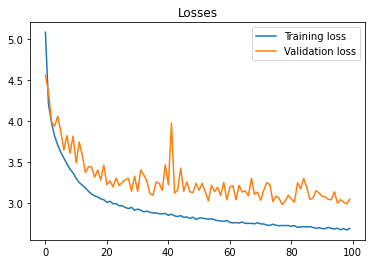

In [131]:
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

nbins = 1000
input_dim = trainX_long.shape[2]
output_dim = 1001
layer_dim = 1
dropout = 0
n_epochs = 100
# learning_rate = 1e-4
weight_decay = 1e-6
max_long = 1
min_long = 0

train_long = TensorDataset(trainX_long, trainY_long)
val_long = TensorDataset(valX_long, valY_long)
test_long = TensorDataset(testX_long, testY_long)

batch_size = [8]
hidden_dim = [16]
learning_rate = [0.01]
    
for batch in batch_size:
    for hd in hidden_dim:
        for lr in learning_rate:
            print("Batch: ", batch, " ", " Hidden dim: ", hd, " ", "Learning rate: ", lr)
            # shuffle = true
            train_loader = DataLoader(train_long, batch_size=batch, shuffle=True, drop_last=True)
            val_loader = DataLoader(val_long, batch_size=batch, shuffle=True, drop_last=True)
            test_loader = DataLoader(test_long, batch_size=batch, shuffle=True, drop_last=True)

            model_params = {'input_dim': input_dim,
                            'hidden_dim' : hd,
                            'layer_dim' : layer_dim,
                            'output_dim' : output_dim,
                            'dropout_prob' : dropout, 
                            'n_past': n_past}

            model = get_model('lstm', model_params).to(device)
            
            loss_func = nn.CrossEntropyLoss()   

            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            opt_long = Optimization_Long(model=model.to(device), loss_fn=loss_func, optimizer=optimizer, max_long=max_long , min_long=min_long , nbins=nbins)
            opt_long.train(train_loader, val_loader, batch, n_epochs, input_dim)
            opt_long.plot_losses()

In [132]:
model_long = torch.load('model_long')

In [133]:
y_pred_long = model_long(testX_long)

In [134]:
y_pred_long = y_pred_long.cpu().detach().numpy()

In [135]:
testY_long = testY_long.cpu().detach().numpy()

In [136]:
pred_conversion_long = []
for i in range(len(y_pred_long)):
    pred_conversion_long.append(np.argmax(y_pred_long[i]))

In [137]:
pred_array_long = np.array(pred_conversion_long)

In [138]:
pred_array_long = pred_array_long[:,None]

In [139]:
pred_array_long = pred_array_long.astype(float)

In [140]:
for i in range(len(pred_array_long)):
    pred_array_long[i] = float(pred_array_long[i]) * float(1/1000)

In [141]:
y_pred_long_origin = scaler_long.inverse_transform(pred_array_long)

In [142]:
y_test_long_origin = scaler_long.inverse_transform(testY_long)

In [143]:
# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(y_test_long_origin, y_pred_long_origin))
print(math.sqrt(mean_squared_error(y_test_long_origin, y_pred_long_origin)))

2.3407712297811685
1.5299579176504066


In [144]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test_long_origin, y_pred_long_origin))
print(math.sqrt(mean_absolute_error(y_test_long_origin, y_pred_long_origin)))

0.5970013718926476
0.7726586386578794


In [145]:
pred = np.concatenate((y_pred_lat_origin, y_pred_long_origin), axis=1)

In [146]:
true = np.concatenate((y_test_lat_origin, y_test_long_origin), axis=1)

In [147]:
print(math.sqrt(mean_squared_error(true, pred)))

1.1390731394379634


### Latitude Prediction (Mangkhut)

In [148]:
df_features_lat_2018_MANGKHUT = df_WP_2018_MANGKHUT[cols_features].astype(float)
df_target_lat_2018_MANGKHUT = df_WP_2018_MANGKHUT[cols_target].astype(float)

In [149]:
df_features_lat_2018_MANGKHUT = df_features_lat_2018_MANGKHUT[cols_features].to_numpy()
df_target_lat_2018_MANGKHUT = df_target_lat_2018_MANGKHUT[cols_target].to_numpy()

In [150]:
X_original_MANGKHURT_lat=[]
Y_original_MANGKHURT_lat=[]

In [151]:
for i in range(n_past, len(df_features_lat_2018_MANGKHUT)-n_future+1):
    X_original_MANGKHURT_lat.append(df_features_lat_2018_MANGKHUT[i-n_past:i,0:df_features_lat_2018_MANGKHUT.shape[1]])
    Y_original_MANGKHURT_lat.append(df_target_lat_2018_MANGKHUT[i+n_future-1:i+n_future,0])

In [152]:
X_original_MANGKHURT_lat, Y_original_MANGKHURT_lat= np.array(X_original_MANGKHURT_lat), np.array(Y_original_MANGKHURT_lat)

In [153]:
X_original_MANGKHURT_lat = torch.from_numpy(X_original_MANGKHURT_lat).float()

In [154]:
y_pred_lat_MANGKHURT = model_lat(X_original_MANGKHURT_lat.to(device))

In [155]:
y_pred_lat_MANGKHURT  = y_pred_lat_MANGKHURT.cpu().detach().numpy()

pred_conversion_lat_MANGKHURT = []
for i in range(len(y_pred_lat_MANGKHURT)):
    pred_conversion_lat_MANGKHURT.append(np.argmax(y_pred_lat_MANGKHURT[i]))
    
pred_conversion_lat_MANGKHURT = np.array(pred_conversion_lat_MANGKHURT)
pred_conversion_lat_MANGKHURT = pred_conversion_lat_MANGKHURT[:,None]
pred_conversion_lat_MANGKHURT = pred_conversion_lat_MANGKHURT.astype(float)
for i in range(len(pred_conversion_lat_MANGKHURT)):
    pred_conversion_lat_MANGKHURT[i] = float(pred_conversion_lat_MANGKHURT[i]) * float(1/1000)
    
y_pred_lat_MANGKHURT = scaler_lat.inverse_transform(pred_conversion_lat_MANGKHURT)

In [156]:
y_pred_lat_MANGKHURT
y_pred_lat_MANGKHURT.tolist()
y_pred_lat_MANGKHURT_formatted = [ '%.2f' % elem for elem in y_pred_lat_MANGKHURT ]
y_pred_lat_MANGKHURT_formatted = [float(i) for i in y_pred_lat_MANGKHURT_formatted]
print(y_pred_lat_MANGKHURT_formatted)
print(len(y_pred_lat_MANGKHURT_formatted))

[12.3, 12.7, 12.8, 13.1, 13.5, 13.7, 13.7, 13.7, 14.4, 14.7, 15.0, 15.3, 15.3, 15.3, 15.6, 15.6, 15.6, 15.6, 15.3, 15.3, 15.0, 14.5, 14.4, 14.4, 14.4, 13.9, 13.9, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 14.0, 13.9, 13.9, 14.0, 14.4, 14.4, 14.4, 14.4, 14.4, 14.7, 14.7, 14.7, 14.9, 14.9, 15.0, 15.3, 15.6, 16.1, 16.1, 17.0, 17.7, 18.0, 18.0, 18.3, 18.4, 18.4, 18.6, 18.6, 19.0, 19.6, 19.6, 19.9, 20.5, 21.1, 21.8, 21.6, 21.5, 21.4, 21.5, 21.6, 21.9, 21.9, 21.9, 22.1, 22.1, 22.1, 22.1, 22.5, 22.7, 23.3, 23.6, 23.6, 23.8]
90


In [157]:
Y_original_MANGKHURT_lat = scaler_lat.inverse_transform(Y_original_MANGKHURT_lat)

In [158]:
# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(Y_original_MANGKHURT_lat, y_pred_lat_MANGKHURT))
print(math.sqrt(mean_squared_error(Y_original_MANGKHURT_lat, y_pred_lat_MANGKHURT)))

0.05624367533333355
0.23715749056973418


### Longitude Prediction (Mangkhut)

In [159]:
df_features_long_2018_MANGKHUT = df_WP_2018_MANGKHUT[cols_features].astype(float)
df_target_long_2018_MANGKHUT = df_WP_2018_MANGKHUT[cols_target_long].astype(float)

In [160]:
df_features_long_2018_MANGKHUT = df_features_long_2018_MANGKHUT[cols_features].to_numpy()
df_target_long_2018_MANGKHUT = df_target_long_2018_MANGKHUT[cols_target_long].to_numpy()

In [161]:
X_original_MANGKHURT_long=[]
Y_original_MANGKHURT_long=[]

In [162]:
for i in range(n_past, len(df_features_long_2018_MANGKHUT)-n_future+1):
    X_original_MANGKHURT_long.append(df_features_long_2018_MANGKHUT[i-n_past:i,0:df_features_long_2018_MANGKHUT.shape[1]])
    Y_original_MANGKHURT_long.append(df_target_long_2018_MANGKHUT[i+n_future-1:i+n_future,0])

In [163]:
X_original_MANGKHURT_long, Y_original_MANGKHURT_long= np.array(X_original_MANGKHURT_long), np.array(Y_original_MANGKHURT_long)

In [164]:
X_original_MANGKHURT_long = torch.from_numpy(X_original_MANGKHURT_long).float()

In [165]:
y_pred_long_MANGKHURT = model_long(X_original_MANGKHURT_long.to(device))

In [166]:
y_pred_long_MANGKHURT  = y_pred_long_MANGKHURT.cpu().detach().numpy()

In [167]:
pred_conversion_long_MANGKHURT = []
for i in range(len(y_pred_long_MANGKHURT)):
    pred_conversion_long_MANGKHURT.append(np.argmax(y_pred_long_MANGKHURT[i]))

In [168]:
pred_conversion_long_MANGKHURT = np.array(pred_conversion_long_MANGKHURT)

In [169]:
pred_conversion_long_MANGKHURT = pred_conversion_long_MANGKHURT[:,None]

In [170]:
pred_conversion_long_MANGKHURT = pred_conversion_long_MANGKHURT.astype(float)

In [171]:
for i in range(len(pred_conversion_long_MANGKHURT)):
    pred_conversion_long_MANGKHURT[i] = float(pred_conversion_long_MANGKHURT[i]) * float(1/1000)

In [172]:
y_pred_long_MANGKHURT = scaler_long.inverse_transform(pred_conversion_long_MANGKHURT)

In [173]:
y_pred_long_MANGKHURT
y_pred_long_MANGKHURT.tolist()
y_pred_long_MANGKHURT_formatted = [ '%.2f' % elem for elem in y_pred_long_MANGKHURT ]
y_pred_long_MANGKHURT_formatted = [float(i) for i in y_pred_long_MANGKHURT_formatted]
print(y_pred_long_MANGKHURT_formatted)
print(len(y_pred_long_MANGKHURT_formatted))

[165.41, 165.41, 165.41, 164.91, 162.91, 162.91, 162.25, 161.92, 160.25, 159.42, 158.76, 157.93, 157.43, 155.93, 154.43, 153.44, 151.61, 151.61, 150.28, 148.94, 148.28, 147.12, 145.95, 145.95, 144.62, 144.62, 143.12, 142.46, 141.13, 141.13, 139.63, 139.13, 138.63, 137.8, 137.3, 136.64, 136.64, 135.81, 135.47, 134.31, 134.31, 134.31, 133.31, 132.81, 132.15, 131.65, 130.65, 129.99, 129.65, 128.66, 128.32, 127.82, 126.83, 126.16, 125.66, 125.66, 125.16, 124.67, 122.84, 122.5, 121.34, 120.51, 120.51, 120.01, 119.51, 118.01, 118.01, 117.02, 116.35, 116.35, 114.19, 114.19, 113.52, 114.19, 113.52, 113.52, 113.52, 112.86, 112.86, 112.53, 112.53, 111.53, 110.53, 110.53, 110.53, 109.37, 108.53, 113.52, 108.53, 106.21]
90


In [174]:
Y_original_MANGKHURT_long = scaler_long.inverse_transform(Y_original_MANGKHURT_long)

In [175]:
print(mean_squared_error(Y_original_MANGKHURT_long, y_pred_long_MANGKHURT))
print(math.sqrt(mean_squared_error(Y_original_MANGKHURT_long, y_pred_long_MANGKHURT)))

0.8915408981111096
0.9442144343903611


In [176]:
pred_2_mang = np.concatenate((y_pred_lat_MANGKHURT, y_pred_long_MANGKHURT), axis=1)

In [177]:
true_2_mang = np.concatenate((Y_original_MANGKHURT_lat, Y_original_MANGKHURT_long), axis=1)

In [178]:
print(math.sqrt(mean_squared_error(true_2_mang, pred_2_mang)))

0.6883983488665713


### Prediction visualisation (MANGKHURT)

In [179]:
print("Actual Lat of Mangkhurt:")
Y_original_MANGKHURT_lat
Y_original_MANGKHURT_lat.tolist()
Y_original_MANGKHURT_lat_formatted = [ '%.2f' % elem for elem in Y_original_MANGKHURT_lat ]
Y_original_MANGKHURT_lat_formatted = [float(i) for i in Y_original_MANGKHURT_lat_formatted]
print(Y_original_MANGKHURT_lat_formatted)
print(len(Y_original_MANGKHURT_lat_formatted))
print("Actual Long of Mangkhurt:")
Y_original_MANGKHURT_long
Y_original_MANGKHURT_long.tolist()
Y_original_MANGKHURT_long_formatted = [ '%.2f' % elem for elem in Y_original_MANGKHURT_long ]
Y_original_MANGKHURT_long_formatted = [float(i) for i in Y_original_MANGKHURT_long_formatted]
print(Y_original_MANGKHURT_long_formatted)
print(len(Y_original_MANGKHURT_long_formatted))

Actual Lat of Mangkhurt:
[12.58, 12.8, 13.06, 13.3, 13.44, 13.6, 13.88, 14.2, 14.47, 14.7, 14.87, 15.0, 15.11, 15.2, 15.27, 15.3, 15.29, 15.2, 15.01, 14.8, 14.63, 14.5, 14.39, 14.3, 14.2, 14.1, 13.98, 13.9, 13.88, 13.9, 13.91, 13.9, 13.84, 13.8, 13.84, 13.9, 13.9, 13.9, 13.93, 14.0, 14.1, 14.2, 14.25, 14.3, 14.39, 14.5, 14.6, 14.7, 14.78, 14.9, 15.07, 15.3, 15.56, 15.9, 16.35, 16.8, 17.13, 17.4, 17.67, 17.9, 18.06, 18.2, 18.38, 18.6, 18.88, 19.2, 19.47, 19.8, 20.3, 20.8, 20.92, 21.03, 21.12, 21.21, 21.3, 21.4, 21.52, 21.65, 21.77, 21.89, 22.0, 22.1, 22.26, 22.4, 22.69, 23.0, 23.22, 23.4, 23.56, 23.7]
90
Actual Long of Mangkhurt:
[165.97, 165.3, 164.44, 163.6, 162.99, 162.4, 161.65, 160.8, 159.89, 158.9, 157.86, 156.8, 155.76, 154.8, 154.01, 153.2, 152.18, 151.1, 150.07, 149.1, 148.24, 147.4, 146.48, 145.6, 144.88, 144.2, 143.46, 142.7, 141.94, 141.2, 140.47, 139.8, 139.25, 138.7, 138.0, 137.3, 136.72, 136.2, 135.72, 135.2, 134.58, 133.9, 133.19, 132.5, 131.88, 131.3, 130.69, 130.1, 129

In [180]:
print("Predicted Lat of Mangkhurt:")
print(y_pred_lat_MANGKHURT_formatted)
print("----------------------------------------------------------------------------------------------")
print("Predicted Long of Mangkhurt:")
print(y_pred_long_MANGKHURT_formatted)

Predicted Lat of Mangkhurt:
[12.3, 12.7, 12.8, 13.1, 13.5, 13.7, 13.7, 13.7, 14.4, 14.7, 15.0, 15.3, 15.3, 15.3, 15.6, 15.6, 15.6, 15.6, 15.3, 15.3, 15.0, 14.5, 14.4, 14.4, 14.4, 13.9, 13.9, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 14.0, 13.9, 13.9, 14.0, 14.4, 14.4, 14.4, 14.4, 14.4, 14.7, 14.7, 14.7, 14.9, 14.9, 15.0, 15.3, 15.6, 16.1, 16.1, 17.0, 17.7, 18.0, 18.0, 18.3, 18.4, 18.4, 18.6, 18.6, 19.0, 19.6, 19.6, 19.9, 20.5, 21.1, 21.8, 21.6, 21.5, 21.4, 21.5, 21.6, 21.9, 21.9, 21.9, 22.1, 22.1, 22.1, 22.1, 22.5, 22.7, 23.3, 23.6, 23.6, 23.8]
----------------------------------------------------------------------------------------------
Predicted Long of Mangkhurt:
[165.41, 165.41, 165.41, 164.91, 162.91, 162.91, 162.25, 161.92, 160.25, 159.42, 158.76, 157.93, 157.43, 155.93, 154.43, 153.44, 151.61, 151.61, 150.28, 148.94, 148.28, 147.12, 145.95, 145.95, 144.62, 144.62, 143.12, 142.46, 141.13, 141.13, 139.63, 139.13, 138.63, 137.8, 137.3, 136.64, 136.64, 135.81, 135.

In [181]:
import os
os.environ['PROJ_LIB'] = r'C:\ProgramData\Anaconda3\pkgs\proj4-5.2.0-h6538335_1006\Library\share'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath

In [182]:
def get_hurricane():
    u = np.array([  [2.444,7.553],
                    [0.513,7.046],
                    [-1.243,5.433],
                    [-2.353,2.975],
                    [-2.578,0.092],
                    [-2.075,-1.795],
                    [-0.336,-2.870],
                    [2.609,-2.016]  ])
    u[:,0] -= 0.098
    codes = [1] + [2]*(len(u)-2) + [2] 
    u = np.append(u, -u[::-1], axis=0)
    codes += codes

    return mpath.Path(3*u, codes, closed=False)

In [183]:
hurricane = get_hurricane()

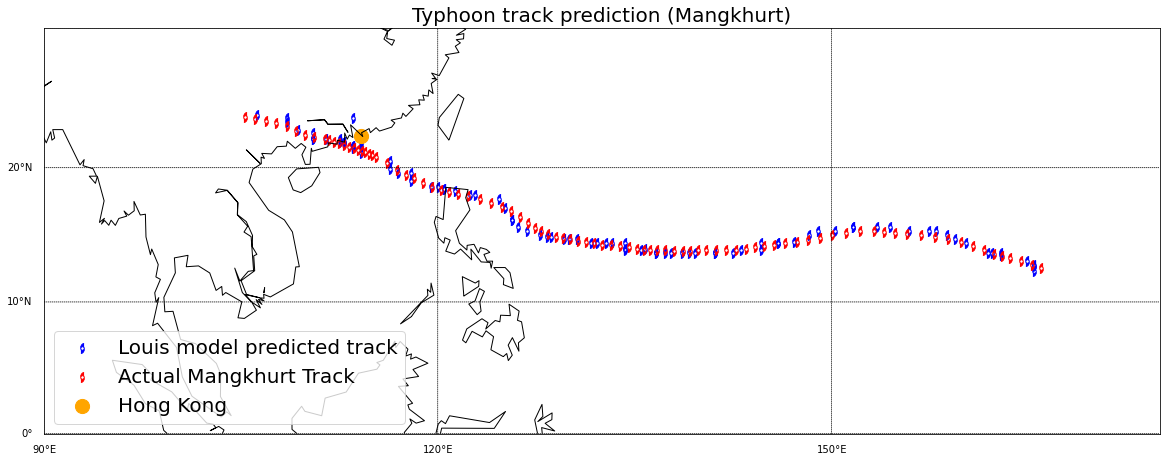

In [184]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 30, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(y_pred_long_MANGKHURT_formatted, y_pred_lat_MANGKHURT_formatted, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(Y_original_MANGKHURT_long, Y_original_MANGKHURT_lat, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual Mangkhurt Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong' )
plt.title('Typhoon track prediction (Mangkhurt)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("2018 Mangkhut only Classification.png")
plt.show()

### Latitude Prediction (2018 KONGREY)

In [185]:
df_features_lat_2018_KONGREY = df_WP_2018_KONGREY[cols_features].astype(float)
df_target_lat_2018_KONGREY = df_WP_2018_KONGREY[cols_target].astype(float)

df_features_lat_2018_KONGREY = df_features_lat_2018_KONGREY[cols_features].to_numpy()
df_target_lat_2018_KONGREY = df_target_lat_2018_KONGREY[cols_target].to_numpy()

X_original_KONGREY_lat=[]
Y_original_KONGREY_lat=[]

for i in range(n_past, len(df_features_lat_2018_KONGREY)-n_future+1):
    X_original_KONGREY_lat.append(df_features_lat_2018_KONGREY[i-n_past:i,0:df_features_lat_2018_KONGREY.shape[1]])
    Y_original_KONGREY_lat.append(df_target_lat_2018_KONGREY[i+n_future-1:i+n_future,0])
    
X_original_KONGREY_lat, Y_original_KONGREY_lat= np.array(X_original_KONGREY_lat), np.array(Y_original_KONGREY_lat)
X_original_KONGREY_lat = torch.from_numpy(X_original_KONGREY_lat).float()
y_pred_lat_KONGREY = model_lat(X_original_KONGREY_lat.to(device))
y_pred_lat_KONGREY  = y_pred_lat_KONGREY.cpu().detach().numpy()

pred_conversion_lat_KONGREY = []
for i in range(len(y_pred_lat_KONGREY)):
    pred_conversion_lat_KONGREY.append(np.argmax(y_pred_lat_KONGREY[i]))

pred_conversion_lat_KONGREY = np.array(pred_conversion_lat_KONGREY)
pred_conversion_lat_KONGREY = pred_conversion_lat_KONGREY[:,None]
pred_conversion_lat_KONGREY = pred_conversion_lat_KONGREY.astype(float)

for i in range(len(pred_conversion_lat_KONGREY)):
    pred_conversion_lat_KONGREY[i] = float(pred_conversion_lat_KONGREY[i]) * float(1/1000)

y_pred_lat_KONGREY = scaler_lat.inverse_transform(pred_conversion_lat_KONGREY)

y_pred_lat_KONGREY_formatted = [ '%.2f' % elem for elem in y_pred_lat_KONGREY ]
y_pred_lat_KONGREY_formatted = [float(i) for i in y_pred_lat_KONGREY_formatted]
print(y_pred_lat_KONGREY_formatted)
print(len(y_pred_lat_KONGREY_formatted))

Y_original_KONGREY_lat = scaler_lat.inverse_transform(Y_original_KONGREY_lat)

# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(Y_original_KONGREY_lat, y_pred_lat_KONGREY))
print(math.sqrt(mean_squared_error(Y_original_KONGREY_lat, y_pred_lat_KONGREY)))

[7.6, 7.6, 8.3, 10.0, 10.2, 10.7, 11.6, 12.4, 13.1, 12.8, 12.8, 12.8, 12.8, 13.1, 13.5, 13.7, 14.0, 14.4, 14.7, 15.0, 15.3, 15.6, 15.6, 15.6, 15.6, 16.1, 16.1, 16.7, 17.3, 17.7, 17.7, 17.7, 17.7, 17.9, 18.4, 18.7, 19.1, 19.6, 20.0, 20.2, 20.2, 20.7, 21.1, 21.8, 22.1, 22.5, 23.1, 23.3, 23.6, 24.2, 24.5, 25.0, 25.9, 26.4, 27.2, 28.0, 28.4, 29.2, 29.9, 31.05, 31.5, 33.0, 33.9, 34.8, 36.1, 37.5, 38.5, 38.5, 40.4, 41.35, 41.5, 42.1]
72
0.11124213831805545
0.3335298162354536


### Longitude Prediction (2018 KONGREY)

In [186]:
df_features_long_2018_KONGREY = df_WP_2018_KONGREY[cols_features].astype(float)
df_target_long_2018_KONGREY= df_WP_2018_KONGREY[cols_target_long].astype(float)

df_features_long_2018_KONGREY = df_features_long_2018_KONGREY[cols_features].to_numpy()
df_target_long_2018_KONGREY = df_target_long_2018_KONGREY[cols_target_long].to_numpy()

X_original_2018_KONGREY_long=[]
Y_original_2018_KONGREY_long=[]

for i in range(n_past, len(df_features_long_2018_KONGREY)-n_future+1):
    X_original_2018_KONGREY_long.append(df_features_long_2018_KONGREY[i-n_past:i,0:df_features_long_2018_KONGREY.shape[1]])
    Y_original_2018_KONGREY_long.append(df_target_long_2018_KONGREY[i+n_future-1:i+n_future,0])
    
X_original_2018_KONGREY_long, Y_original_2018_KONGREY_long= np.array(X_original_2018_KONGREY_long), np.array(Y_original_2018_KONGREY_long)    
X_original_2018_KONGREY_long = torch.from_numpy(X_original_2018_KONGREY_long).float()
y_pred_long_2018_KONGREY = model_long(X_original_2018_KONGREY_long.to(device))
y_pred_long_2018_KONGREY  = y_pred_long_2018_KONGREY.cpu().detach().numpy()

pred_conversion_long_KONGREY = []
for i in range(len(y_pred_long_2018_KONGREY)):
    pred_conversion_long_KONGREY.append(np.argmax(y_pred_long_2018_KONGREY[i]))

pred_conversion_long_KONGREY = np.array(pred_conversion_long_KONGREY)
pred_conversion_long_KONGREY = pred_conversion_long_KONGREY[:,None]
pred_conversion_long_KONGREY = pred_conversion_long_KONGREY.astype(float)

for i in range(len(pred_conversion_long_KONGREY)):
    pred_conversion_long_KONGREY[i] = float(pred_conversion_long_KONGREY[i]) * float(1/1000)

y_pred_long_2018_KONGREY = scaler_long.inverse_transform(pred_conversion_long_KONGREY)

y_pred_long_KONGREY_formatted = [ '%.2f' % elem for elem in y_pred_long_2018_KONGREY ]
y_pred_long_KONGREY_formatted = [float(i) for i in y_pred_long_KONGREY_formatted]
print(y_pred_long_KONGREY_formatted)
print(len(y_pred_long_KONGREY_formatted))

Y_original_2018_KONGREY_long = scaler_long.inverse_transform(Y_original_2018_KONGREY_long)

print(mean_squared_error(Y_original_2018_KONGREY_long, y_pred_long_2018_KONGREY))
print(math.sqrt(mean_squared_error(Y_original_2018_KONGREY_long, y_pred_long_2018_KONGREY)))

[150.28, 150.28, 148.94, 148.28, 147.61, 146.95, 145.95, 145.62, 144.62, 143.12, 141.13, 139.63, 139.63, 139.13, 138.63, 138.63, 137.8, 137.8, 137.3, 137.14, 136.64, 136.64, 136.64, 135.81, 135.47, 135.47, 134.31, 134.31, 134.31, 133.81, 133.31, 132.81, 132.48, 132.15, 131.65, 131.65, 130.98, 130.65, 129.99, 129.65, 129.16, 129.16, 129.16, 129.16, 128.66, 128.66, 127.82, 127.82, 127.82, 126.83, 126.83, 126.83, 126.16, 125.66, 125.66, 125.66, 125.66, 125.66, 125.66, 125.66, 125.66, 125.66, 125.66, 127.66, 129.99, 130.65, 131.65, 132.98, 134.31, 135.47, 137.8, 139.96]
72
0.2946832775000019
0.5428473795644609


In [187]:
pred_2_kong = np.concatenate((y_pred_lat_KONGREY, y_pred_long_2018_KONGREY), axis=1)

In [188]:
true_2_kong = np.concatenate((Y_original_KONGREY_lat, Y_original_2018_KONGREY_long), axis=1)

In [189]:
print(math.sqrt(mean_squared_error(true_2_kong, pred_2_kong)))

0.45051382654589933


### Prediction visualisation (2018 KONGREY)

In [190]:
print("Actual Lat of KONGREY:")
Y_original_KONGREY_lat_formatted = [ '%.2f' % elem for elem in Y_original_KONGREY_lat ]
Y_original_KONGREY_lat_formatted = [float(i) for i in Y_original_KONGREY_lat_formatted]
print(Y_original_KONGREY_lat_formatted)
print(len(Y_original_KONGREY_lat_formatted))
print("Actual Long of KONGREY:")
Y_original_KONGREY_long_formatted = [ '%.2f' % elem for elem in Y_original_2018_KONGREY_long ]
Y_original_KONGREY_long_formatted = [float(i) for i in Y_original_KONGREY_long_formatted]
print(Y_original_KONGREY_long_formatted)
print(len(Y_original_KONGREY_long_formatted))

Actual Lat of KONGREY:
[8.05, 8.8, 9.24, 9.7, 10.42, 11.2, 11.9, 12.2, 12.39, 12.5, 12.58, 12.7, 12.98, 13.3, 13.54, 13.8, 14.15, 14.5, 14.78, 15.0, 15.17, 15.3, 15.43, 15.6, 15.82, 16.1, 16.45, 16.8, 17.08, 17.3, 17.44, 17.6, 17.87, 18.2, 18.54, 18.9, 19.27, 19.6, 19.85, 20.1, 20.43, 20.8, 21.19, 21.6, 22.0, 22.4, 22.77, 23.2, 23.78, 24.4, 24.94, 25.5, 26.15, 26.8, 27.34, 27.9, 28.58, 29.4, 30.41, 31.4, 32.08, 32.8, 33.85, 35.0, 36.09, 37.1, 37.91, 38.7, 39.72, 40.7, 41.43, 42.0]
72
Actual Long of KONGREY:
[150.38, 149.6, 148.8, 148.0, 147.29, 146.5, 145.5, 144.2, 143.1, 142.2, 141.38, 140.7, 140.1, 139.6, 139.19, 138.8, 138.34, 137.9, 137.53, 137.2, 136.84, 136.5, 136.2, 135.9, 135.56, 135.2, 134.81, 134.4, 134.01, 133.6, 133.14, 132.7, 132.34, 132.0, 131.62, 131.2, 130.74, 130.3, 129.97, 129.7, 129.44, 129.2, 128.96, 128.7, 128.4, 128.1, 127.84, 127.6, 127.35, 127.1, 126.85, 126.6, 126.34, 126.1, 125.86, 125.7, 125.72, 125.8, 125.74, 125.8, 126.11, 126.7, 127.58, 128.6, 129.42, 130.

In [191]:
print("Predicted Lat of KONGREY:")
print(y_pred_lat_KONGREY_formatted)
print("----------------------------------------------------------------------------------------------")
print("Predicted Long of KONGREY:")
print(y_pred_long_KONGREY_formatted)

Predicted Lat of KONGREY:
[7.6, 7.6, 8.3, 10.0, 10.2, 10.7, 11.6, 12.4, 13.1, 12.8, 12.8, 12.8, 12.8, 13.1, 13.5, 13.7, 14.0, 14.4, 14.7, 15.0, 15.3, 15.6, 15.6, 15.6, 15.6, 16.1, 16.1, 16.7, 17.3, 17.7, 17.7, 17.7, 17.7, 17.9, 18.4, 18.7, 19.1, 19.6, 20.0, 20.2, 20.2, 20.7, 21.1, 21.8, 22.1, 22.5, 23.1, 23.3, 23.6, 24.2, 24.5, 25.0, 25.9, 26.4, 27.2, 28.0, 28.4, 29.2, 29.9, 31.05, 31.5, 33.0, 33.9, 34.8, 36.1, 37.5, 38.5, 38.5, 40.4, 41.35, 41.5, 42.1]
----------------------------------------------------------------------------------------------
Predicted Long of KONGREY:
[150.28, 150.28, 148.94, 148.28, 147.61, 146.95, 145.95, 145.62, 144.62, 143.12, 141.13, 139.63, 139.63, 139.13, 138.63, 138.63, 137.8, 137.8, 137.3, 137.14, 136.64, 136.64, 136.64, 135.81, 135.47, 135.47, 134.31, 134.31, 134.31, 133.81, 133.31, 132.81, 132.48, 132.15, 131.65, 131.65, 130.98, 130.65, 129.99, 129.65, 129.16, 129.16, 129.16, 129.16, 128.66, 128.66, 127.82, 127.82, 127.82, 126.83, 126.83, 126.83, 126.16

In [192]:
hurricane = get_hurricane()

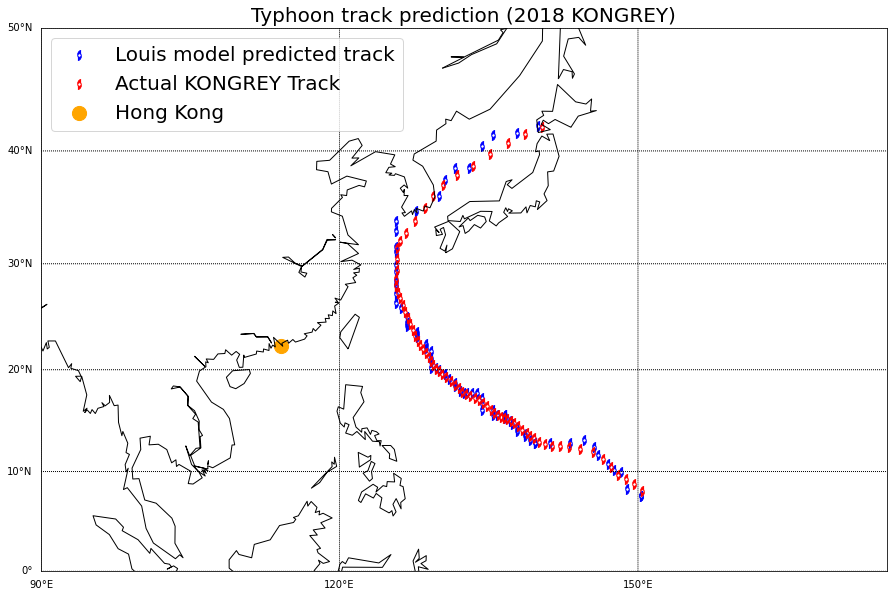

In [193]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 50, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(y_pred_long_KONGREY_formatted, y_pred_lat_KONGREY_formatted, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(Y_original_2018_KONGREY_long, Y_original_KONGREY_lat, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual KONGREY Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong' )
plt.title('Typhoon track prediction (2018 KONGREY)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("Classification 2018_KONGREY.png")
plt.show()

### Latitude Prediction (2018 YUTU)

In [194]:
df_features_lat_2018_YUTU = df_WP_2018_YUTU[cols_features].astype(float)
df_target_lat_2018_YUTU = df_WP_2018_YUTU[cols_target].astype(float)

df_features_lat_2018_YUTU = df_features_lat_2018_YUTU[cols_features].to_numpy()
df_target_lat_2018_YUTU = df_target_lat_2018_YUTU[cols_target].to_numpy()

X_original_YUTU_lat=[]
Y_original_YUTU_lat=[]

for i in range(n_past, len(df_features_lat_2018_YUTU)-n_future+1):
    X_original_YUTU_lat.append(df_features_lat_2018_YUTU[i-n_past:i,0:df_features_lat_2018_YUTU.shape[1]])
    Y_original_YUTU_lat.append(df_target_lat_2018_YUTU[i+n_future-1:i+n_future,0])
    
X_original_YUTU_lat, Y_original_YUTU_lat= np.array(X_original_YUTU_lat), np.array(Y_original_YUTU_lat)
X_original_YUTU_lat = torch.from_numpy(X_original_YUTU_lat).float()
y_pred_lat_YUTU = model_lat(X_original_YUTU_lat.to(device))
y_pred_lat_YUTU  = y_pred_lat_YUTU.cpu().detach().numpy()


pred_conversion_lat_YUTU = []
for i in range(len(y_pred_lat_YUTU)):
    pred_conversion_lat_YUTU.append(np.argmax(y_pred_lat_YUTU[i]))

pred_conversion_lat_YUTU = np.array(pred_conversion_lat_YUTU)
pred_conversion_lat_YUTU = pred_conversion_lat_YUTU[:,None]
pred_conversion_lat_YUTU = pred_conversion_lat_YUTU.astype(float)

for i in range(len(pred_conversion_lat_YUTU)):
    pred_conversion_lat_YUTU[i] = float(pred_conversion_lat_YUTU[i]) * float(1/1000)


y_pred_lat_YUTU = scaler_lat.inverse_transform(pred_conversion_lat_YUTU)

y_pred_lat_YUTU_formatted = [ '%.2f' % elem for elem in y_pred_lat_YUTU ]
y_pred_lat_YUTU_formatted = [float(i) for i in y_pred_lat_YUTU_formatted]
print(y_pred_lat_YUTU_formatted)
print(len(y_pred_lat_YUTU_formatted))

Y_original_YUTU_lat = scaler_lat.inverse_transform(Y_original_YUTU_lat)

# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(Y_original_YUTU_lat, y_pred_lat_YUTU))
print(math.sqrt(mean_squared_error(Y_original_YUTU_lat, y_pred_lat_YUTU)))

[8.6, 8.6, 8.6, 8.6, 8.6, 9.1, 9.4, 10.0, 10.2, 10.6, 10.6, 10.9, 11.1, 11.4, 11.6, 12.0, 12.0, 12.1, 12.1, 12.1, 12.8, 13.5, 13.7, 14.0, 14.4, 14.7, 14.7, 15.3, 15.6, 16.1, 16.1, 16.1, 16.1, 16.1, 16.1, 16.7, 16.7, 16.8, 16.8, 17.3, 17.3, 17.3, 17.7, 17.7, 17.7, 17.7, 17.9, 17.9, 17.9, 17.9, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 17.9, 17.75, 17.5, 17.1, 16.8, 16.4, 16.4, 16.8, 16.8, 16.8, 16.8, 16.8, 16.8, 16.8, 16.8, 16.5, 16.5, 16.1, 17.3, 17.3, 17.3, 18.0, 18.3, 18.6, 18.6, 18.6, 18.7, 19.0, 19.6, 19.6, 19.9, 20.1, 20.1, 20.1, 20.1, 20.1, 20.7, 20.9, 20.7, 20.7, 20.1, 20.1, 19.8, 19.8, 19.6, 19.6]
104
0.0482795222826924
0.2197260163992703


### Longitude Prediction (2018 YUTU)

In [195]:
df_features_long_2018_YUTU = df_WP_2018_YUTU[cols_features].astype(float)
df_target_long_2018_YUTU= df_WP_2018_YUTU[cols_target_long].astype(float)

df_features_long_2018_YUTU = df_features_long_2018_YUTU[cols_features].to_numpy()
df_target_long_2018_YUTU = df_target_long_2018_YUTU[cols_target_long].to_numpy()

X_original_2018_YUTU_long=[]
Y_original_2018_YUTU_long=[]

for i in range(n_past, len(df_features_long_2018_YUTU)-n_future+1):
    X_original_2018_YUTU_long.append(df_features_long_2018_YUTU[i-n_past:i,0:df_features_long_2018_YUTU.shape[1]])
    Y_original_2018_YUTU_long.append(df_target_long_2018_YUTU[i+n_future-1:i+n_future,0])
    
X_original_2018_YUTU_long, Y_original_2018_YUTU_long= np.array(X_original_2018_YUTU_long), np.array(Y_original_2018_YUTU_long)    
X_original_2018_YUTU_long = torch.from_numpy(X_original_2018_YUTU_long).float()
y_pred_long_2018_YUTU = model_long(X_original_2018_YUTU_long.to(device))
y_pred_long_2018_YUTU  = y_pred_long_2018_YUTU.cpu().detach().numpy()


pred_conversion_long_YUTU = []
for i in range(len(y_pred_long_2018_YUTU)):
    pred_conversion_long_YUTU.append(np.argmax(y_pred_long_2018_YUTU[i]))

pred_conversion_long_YUTU = np.array(pred_conversion_long_YUTU)
pred_conversion_long_YUTU = pred_conversion_long_YUTU[:,None]
pred_conversion_long_YUTU = pred_conversion_long_YUTU.astype(float)

for i in range(len(pred_conversion_long_YUTU)):
    pred_conversion_long_YUTU[i] = float(pred_conversion_long_YUTU[i]) * float(1/1000)


y_pred_long_2018_YUTU = scaler_long.inverse_transform(pred_conversion_long_YUTU)

y_pred_long_YUTU_formatted = [ '%.2f' % elem for elem in y_pred_long_2018_YUTU ]
y_pred_long_YUTU_formatted = [float(i) for i in y_pred_long_YUTU_formatted]
print(y_pred_long_YUTU_formatted)
print(len(y_pred_long_YUTU_formatted))

Y_original_2018_YUTU_long = scaler_long.inverse_transform(Y_original_2018_YUTU_long)

print(mean_squared_error(Y_original_2018_YUTU_long, y_pred_long_2018_YUTU))
print(math.sqrt(mean_squared_error(Y_original_2018_YUTU_long, y_pred_long_2018_YUTU)))

[157.93, 157.43, 157.43, 156.1, 156.1, 155.93, 155.26, 154.43, 153.6, 153.6, 153.1, 152.44, 151.61, 151.61, 150.28, 150.28, 148.94, 148.28, 148.28, 148.28, 147.61, 147.61, 147.61, 145.95, 145.95, 145.95, 145.95, 144.62, 144.62, 144.62, 143.12, 143.12, 143.12, 142.46, 142.29, 141.13, 141.13, 141.13, 139.63, 139.13, 138.63, 137.3, 136.64, 136.64, 135.81, 134.31, 134.31, 133.31, 132.81, 132.15, 131.65, 130.98, 130.65, 129.99, 129.65, 129.32, 128.66, 127.82, 126.83, 126.83, 126.16, 125.66, 125.66, 124.83, 124.67, 124.0, 123.5, 122.5, 122.5, 122.0, 120.34, 119.51, 119.51, 119.01, 119.01, 120.01, 118.01, 118.01, 118.01, 118.01, 117.51, 117.51, 117.51, 117.51, 116.35, 116.35, 116.35, 116.35, 116.35, 116.35, 116.35, 116.35, 116.35, 116.85, 116.85, 117.02, 116.85, 116.35, 116.35, 116.85, 116.35, 116.35, 115.52, 115.52]
104
0.22796173480769186
0.4774533849578321


In [196]:
pred_2_yutu = np.concatenate((y_pred_lat_YUTU, y_pred_long_2018_YUTU), axis=1)

In [197]:
true_2_yutu = np.concatenate((Y_original_YUTU_lat, Y_original_2018_YUTU_long), axis=1)

In [198]:
print(math.sqrt(mean_squared_error(true_2_yutu, pred_2_yutu)))

0.37164583751899083


### Prediction visualisation (2018 YUTU)

In [199]:
print("Actual Lat of YUTU:")
Y_original_YUTU_lat_formatted = [ '%.2f' % elem for elem in Y_original_YUTU_lat ]
Y_original_YUTU_lat_formatted = [float(i) for i in Y_original_YUTU_lat_formatted]
print(Y_original_YUTU_lat_formatted)
print(len(Y_original_YUTU_lat_formatted))
print("Actual Long of YUTU:")
Y_original_YUTU_long_formatted = [ '%.2f' % elem for elem in Y_original_2018_YUTU_long ]
Y_original_YUTU_long_formatted = [float(i) for i in Y_original_YUTU_long_formatted]
print(Y_original_YUTU_long_formatted)
print(len(Y_original_YUTU_long_formatted))

Actual Lat of YUTU:
[8.33, 8.4, 8.51, 8.7, 8.98, 9.3, 9.61, 9.9, 10.16, 10.4, 10.65, 10.9, 11.16, 11.4, 11.62, 11.8, 11.88, 12.0, 12.32, 12.7, 13.01, 13.3, 13.59, 13.9, 14.24, 14.6, 14.96, 15.3, 15.59, 15.8, 15.92, 16.0, 16.09, 16.2, 16.35, 16.5, 16.6, 16.7, 16.85, 17.0, 17.1, 17.2, 17.35, 17.5, 17.61, 17.7, 17.76, 17.8, 17.86, 17.9, 17.91, 17.9, 17.9, 17.9, 17.91, 17.9, 17.82, 17.7, 17.57, 17.4, 17.13, 16.9, 16.81, 16.8, 16.8, 16.8, 16.74, 16.7, 16.75, 16.8, 16.77, 16.7, 16.56, 16.5, 16.65, 16.9, 17.13, 17.4, 17.77, 18.1, 18.26, 18.4, 18.64, 18.9, 19.1, 19.3, 19.55, 19.8, 20.02, 20.2, 20.31, 20.4, 20.57, 20.7, 20.75, 20.7, 20.57, 20.4, 20.24, 20.1, 20.01, 19.9, 19.72, 19.5]
104
Actual Long of YUTU:
[157.97, 157.6, 157.17, 156.7, 156.14, 155.6, 155.19, 154.8, 154.31, 153.8, 153.31, 152.8, 152.21, 151.6, 151.03, 150.5, 150.02, 149.6, 149.25, 148.9, 148.47, 148.0, 147.55, 147.1, 146.66, 146.2, 145.72, 145.2, 144.64, 144.1, 143.63, 143.2, 142.74, 142.3, 141.92, 141.5, 140.93, 140.3, 139.7

In [200]:
print("Predicted Lat of YUTU:")
print(y_pred_lat_YUTU_formatted)
print("----------------------------------------------------------------------------------------------")
print("Predicted Long of YUTU:")
print(y_pred_long_YUTU_formatted)

Predicted Lat of YUTU:
[8.6, 8.6, 8.6, 8.6, 8.6, 9.1, 9.4, 10.0, 10.2, 10.6, 10.6, 10.9, 11.1, 11.4, 11.6, 12.0, 12.0, 12.1, 12.1, 12.1, 12.8, 13.5, 13.7, 14.0, 14.4, 14.7, 14.7, 15.3, 15.6, 16.1, 16.1, 16.1, 16.1, 16.1, 16.1, 16.7, 16.7, 16.8, 16.8, 17.3, 17.3, 17.3, 17.7, 17.7, 17.7, 17.7, 17.9, 17.9, 17.9, 17.9, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 17.9, 17.75, 17.5, 17.1, 16.8, 16.4, 16.4, 16.8, 16.8, 16.8, 16.8, 16.8, 16.8, 16.8, 16.8, 16.5, 16.5, 16.1, 17.3, 17.3, 17.3, 18.0, 18.3, 18.6, 18.6, 18.6, 18.7, 19.0, 19.6, 19.6, 19.9, 20.1, 20.1, 20.1, 20.1, 20.1, 20.7, 20.9, 20.7, 20.7, 20.1, 20.1, 19.8, 19.8, 19.6, 19.6]
----------------------------------------------------------------------------------------------
Predicted Long of YUTU:
[157.93, 157.43, 157.43, 156.1, 156.1, 155.93, 155.26, 154.43, 153.6, 153.6, 153.1, 152.44, 151.61, 151.61, 150.28, 150.28, 148.94, 148.28, 148.28, 148.28, 147.61, 147.61, 147.61, 145.95, 145.95, 145.95, 145.95, 144.62, 144.62, 144.62, 143

In [201]:
hurricane = get_hurricane()

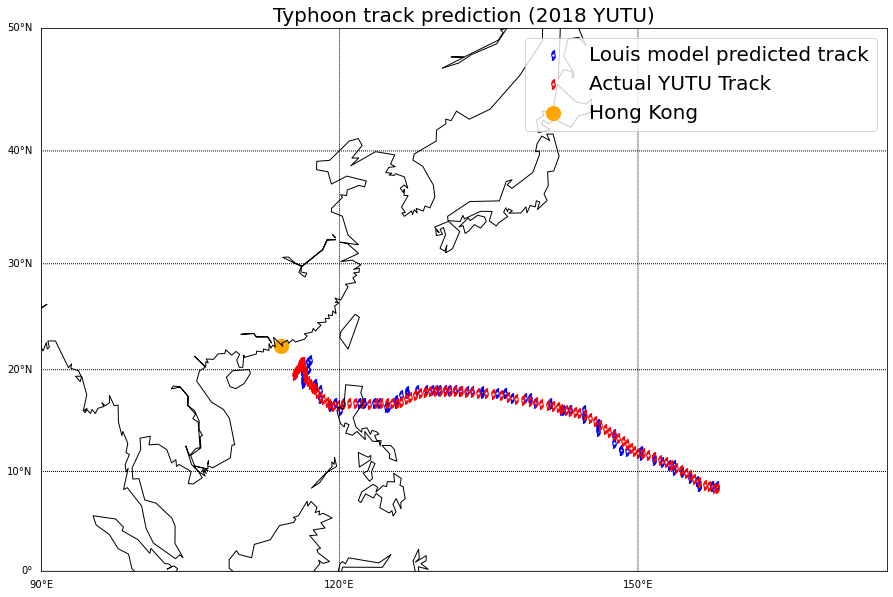

In [202]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 50, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(y_pred_long_YUTU_formatted, y_pred_lat_YUTU_formatted, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(Y_original_2018_YUTU_long, Y_original_YUTU_lat, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual YUTU Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong')
plt.title('Typhoon track prediction (2018 YUTU)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("Classification 2018_YUTU.png")
plt.show()

### Latitude Prediction (2019 WUTIP)

In [203]:
df_features_lat_2019_WUTIP = df_WP_2019_WUTIP[cols_features].astype(float)
df_target_lat_2019_WUTIP = df_WP_2019_WUTIP[cols_target].astype(float)

df_features_lat_2019_WUTIP = df_features_lat_2019_WUTIP[cols_features].to_numpy()
df_target_lat_2019_WUTIP = df_target_lat_2019_WUTIP[cols_target].to_numpy()

X_original_WUTIP_lat=[]
Y_original_WUTIP_lat=[]

for i in range(n_past, len(df_features_lat_2019_WUTIP)-n_future+1):
    X_original_WUTIP_lat.append(df_features_lat_2019_WUTIP[i-n_past:i,0:df_features_lat_2019_WUTIP.shape[1]])
    Y_original_WUTIP_lat.append(df_target_lat_2019_WUTIP[i+n_future-1:i+n_future,0])
    
X_original_WUTIP_lat, Y_original_WUTIP_lat= np.array(X_original_WUTIP_lat), np.array(Y_original_WUTIP_lat)
X_original_WUTIP_lat = torch.from_numpy(X_original_WUTIP_lat).float()
y_pred_lat_WUTIP = model_lat(X_original_WUTIP_lat.to(device))
y_pred_lat_WUTIP  = y_pred_lat_WUTIP.cpu().detach().numpy()

pred_conversion_lat_WUTIP = []
for i in range(len(y_pred_lat_WUTIP)):
    pred_conversion_lat_WUTIP.append(np.argmax(y_pred_lat_WUTIP[i]))

pred_conversion_lat_WUTIP = np.array(pred_conversion_lat_WUTIP)
pred_conversion_lat_WUTIP = pred_conversion_lat_WUTIP[:,None]
pred_conversion_lat_WUTIP = pred_conversion_lat_WUTIP.astype(float)

for i in range(len(pred_conversion_lat_WUTIP)):
    pred_conversion_lat_WUTIP[i] = float(pred_conversion_lat_WUTIP[i]) * float(1/1000)


y_pred_lat_WUTIP = scaler_lat.inverse_transform(pred_conversion_lat_WUTIP)

y_pred_lat_WUTIP_formatted = [ '%.2f' % elem for elem in y_pred_lat_WUTIP ]
y_pred_lat_WUTIP_formatted = [float(i) for i in y_pred_lat_WUTIP_formatted]
print(y_pred_lat_WUTIP_formatted)
print(len(y_pred_lat_WUTIP_formatted))

Y_original_WUTIP_lat = scaler_lat.inverse_transform(Y_original_WUTIP_lat)

# import MSE for accurarcy metrics
from sklearn.metrics import mean_squared_error
import math

print(mean_squared_error(Y_original_WUTIP_lat, y_pred_lat_WUTIP))
print(math.sqrt(mean_squared_error(Y_original_WUTIP_lat, y_pred_lat_WUTIP)))

[5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 4.7, 4.7, 4.5, 4.5, 4.7, 4.6, 5.5, 6.0, 6.6, 6.9, 6.9, 6.9, 6.9, 7.6, 7.6, 7.6, 7.6, 8.3, 9.0, 9.1, 9.6, 10.2, 10.7, 10.9, 10.7, 10.7, 11.2, 11.6, 11.6, 12.15, 12.8, 12.8, 12.0, 12.7, 13.1, 12.8, 13.1, 13.3, 13.5, 13.3, 13.3, 13.3, 13.5, 13.7, 13.7, 13.9, 14.4, 14.4, 14.7, 14.7, 14.7, 15.0, 15.3, 15.3, 15.6, 15.6, 15.6, 15.6, 16.1, 16.1, 16.1, 16.5, 16.7, 16.7, 16.7, 16.8, 17.3, 17.3, 17.7, 17.7, 18.0, 18.3, 18.5, 18.5, 19.0]
81
0.10797340122345696
0.32859306326131865


### Longitude Prediction (2019 WUTIP)

In [204]:
df_features_long_2019_WUTIP = df_WP_2019_WUTIP[cols_features].astype(float)
df_target_long_2019_WUTIP= df_WP_2019_WUTIP[cols_target_long].astype(float)

df_features_long_2019_WUTIP = df_features_long_2019_WUTIP[cols_features].to_numpy()
df_target_long_2019_WUTIP = df_target_long_2019_WUTIP[cols_target_long].to_numpy()

X_original_2019_WUTIP_long=[]
Y_original_2019_WUTIP_long=[]

for i in range(n_past, len(df_features_long_2019_WUTIP)-n_future+1):
    X_original_2019_WUTIP_long.append(df_features_long_2019_WUTIP[i-n_past:i,0:df_features_long_2019_WUTIP.shape[1]])
    Y_original_2019_WUTIP_long.append(df_target_long_2019_WUTIP[i+n_future-1:i+n_future,0])
    
X_original_2019_WUTIP_long, Y_original_2019_WUTIP_long= np.array(X_original_2019_WUTIP_long), np.array(Y_original_2019_WUTIP_long)    
X_original_2019_WUTIP_long = torch.from_numpy(X_original_2019_WUTIP_long).float()
y_pred_long_2019_WUTIP = model_long(X_original_2019_WUTIP_long.to(device))
y_pred_long_2019_WUTIP  = y_pred_long_2019_WUTIP.cpu().detach().numpy()

pred_conversion_long_WUTIP = []
for i in range(len(y_pred_long_2019_WUTIP)):
    pred_conversion_long_WUTIP.append(np.argmax(y_pred_long_2019_WUTIP[i]))

pred_conversion_long_WUTIP = np.array(pred_conversion_long_WUTIP)
pred_conversion_long_WUTIP = pred_conversion_long_WUTIP[:,None]
pred_conversion_long_WUTIP = pred_conversion_long_WUTIP.astype(float)

for i in range(len(pred_conversion_long_WUTIP)):
    pred_conversion_long_WUTIP[i] = float(pred_conversion_long_WUTIP[i]) * float(1/1000)


y_pred_long_2019_WUTIP = scaler_long.inverse_transform(pred_conversion_long_WUTIP)

y_pred_long_WUTIP_formatted = [ '%.2f' % elem for elem in y_pred_long_2019_WUTIP ]
y_pred_long_WUTIP_formatted = [float(i) for i in y_pred_long_WUTIP_formatted]
print(y_pred_long_WUTIP_formatted)
print(len(y_pred_long_WUTIP_formatted))

Y_original_2019_WUTIP_long = scaler_long.inverse_transform(Y_original_2019_WUTIP_long)

print(mean_squared_error(Y_original_2019_WUTIP_long, y_pred_long_2019_WUTIP))
print(math.sqrt(mean_squared_error(Y_original_2019_WUTIP_long, y_pred_long_2019_WUTIP)))

[160.25, 157.93, 157.93, 157.43, 156.1, 156.1, 154.77, 154.77, 153.6, 153.1, 151.11, 150.94, 150.77, 150.77, 150.28, 149.61, 148.94, 148.28, 148.28, 148.28, 148.28, 147.61, 147.61, 147.12, 145.95, 145.95, 145.95, 145.95, 144.62, 144.62, 143.12, 143.12, 143.12, 143.12, 143.12, 143.12, 143.12, 141.96, 142.46, 142.46, 141.96, 141.13, 141.13, 141.13, 141.13, 141.13, 140.46, 139.63, 139.63, 139.63, 139.63, 139.63, 139.63, 139.63, 139.63, 139.13, 139.13, 139.13, 139.13, 139.13, 139.13, 139.63, 139.63, 140.13, 140.13, 140.13, 140.13, 140.13, 140.13, 139.13, 138.63, 137.8, 137.14, 136.64, 135.81, 135.47, 134.31, 134.31, 134.31, 134.31, 134.31]
81
0.3954072255555562
0.6288141422992617


In [205]:
pred_2_wutip = np.concatenate((y_pred_lat_WUTIP, y_pred_long_2019_WUTIP), axis=1)

In [206]:
true_2_wutip = np.concatenate((Y_original_WUTIP_lat, Y_original_2019_WUTIP_long), axis=1)

In [207]:
print(math.sqrt(mean_squared_error(true_2_wutip, pred_2_wutip)))

0.5016874658485166


### Prediction visualisation (2019 WUTIP)

In [208]:
print("Actual Lat of WUTIP:")
Y_original_WUTIP_lat_formatted = [ '%.2f' % elem for elem in Y_original_WUTIP_lat ]
Y_original_WUTIP_lat_formatted = [float(i) for i in Y_original_WUTIP_lat_formatted]
print(Y_original_WUTIP_lat_formatted)
print(len(Y_original_WUTIP_lat_formatted))
print("Actual Long of WUTIP:")
Y_original_WUTIP_long_formatted = [ '%.2f' % elem for elem in Y_original_2019_WUTIP_long]
Y_original_WUTIP_long_formatted = [float(i) for i in Y_original_WUTIP_long_formatted]
print(Y_original_WUTIP_long_formatted)
print(len(Y_original_WUTIP_long_formatted))

Actual Lat of WUTIP:
[4.98, 4.9, 4.74, 4.6, 4.57, 4.6, 4.63, 4.7, 4.83, 5.0, 5.13, 5.3, 5.54, 5.8, 6.01, 6.2, 6.39, 6.6, 6.83, 7.1, 7.39, 7.7, 7.98, 8.3, 8.68, 9.1, 9.54, 9.9, 10.07, 10.2, 10.42, 10.7, 11.03, 11.4, 11.8, 11.9, 12.0, 12.2, 12.4, 12.51, 12.6, 12.76, 12.9, 12.97, 13.0, 13.03, 13.1, 13.23, 13.4, 13.59, 13.8, 14.0, 14.2, 14.41, 14.6, 14.76, 14.9, 15.06, 15.2, 15.31, 15.4, 15.5, 15.6, 15.69, 15.8, 16.0, 16.2, 16.31, 16.4, 16.54, 16.7, 16.89, 17.1, 17.29, 17.5, 17.8, 18.1, 18.31, 18.5, 18.74, 19.0]
81
Actual Long of WUTIP:
[159.03, 158.4, 157.69, 157.0, 156.44, 155.9, 155.24, 154.6, 154.09, 153.6, 153.06, 152.5, 151.88, 151.3, 150.82, 150.4, 149.99, 149.6, 149.2, 148.8, 148.41, 148.0, 147.56, 147.1, 146.62, 146.1, 145.54, 145.0, 144.5, 144.1, 143.87, 143.7, 143.45, 143.2, 142.96, 142.9, 142.8, 142.6, 142.4, 142.25, 142.1, 141.92, 141.7, 141.4, 141.1, 140.88, 140.7, 140.53, 140.4, 140.28, 140.2, 140.15, 140.1, 139.99, 139.9, 139.88, 139.9, 139.88, 139.9, 140.0, 140.1, 140.12, 

In [209]:
print("Predicted Lat of WUTIP:")
print(y_pred_lat_WUTIP_formatted)
print("----------------------------------------------------------------------------------------------")
print("Predicted Long of WUTIP:")
print(y_pred_long_WUTIP_formatted)

Predicted Lat of WUTIP:
[5.3, 5.3, 5.3, 5.3, 5.3, 5.3, 4.7, 4.7, 4.5, 4.5, 4.7, 4.6, 5.5, 6.0, 6.6, 6.9, 6.9, 6.9, 6.9, 7.6, 7.6, 7.6, 7.6, 8.3, 9.0, 9.1, 9.6, 10.2, 10.7, 10.9, 10.7, 10.7, 11.2, 11.6, 11.6, 12.15, 12.8, 12.8, 12.0, 12.7, 13.1, 12.8, 13.1, 13.3, 13.5, 13.3, 13.3, 13.3, 13.5, 13.7, 13.7, 13.9, 14.4, 14.4, 14.7, 14.7, 14.7, 15.0, 15.3, 15.3, 15.6, 15.6, 15.6, 15.6, 16.1, 16.1, 16.1, 16.5, 16.7, 16.7, 16.7, 16.8, 17.3, 17.3, 17.7, 17.7, 18.0, 18.3, 18.5, 18.5, 19.0]
----------------------------------------------------------------------------------------------
Predicted Long of WUTIP:
[160.25, 157.93, 157.93, 157.43, 156.1, 156.1, 154.77, 154.77, 153.6, 153.1, 151.11, 150.94, 150.77, 150.77, 150.28, 149.61, 148.94, 148.28, 148.28, 148.28, 148.28, 147.61, 147.61, 147.12, 145.95, 145.95, 145.95, 145.95, 144.62, 144.62, 143.12, 143.12, 143.12, 143.12, 143.12, 143.12, 143.12, 141.96, 142.46, 142.46, 141.96, 141.13, 141.13, 141.13, 141.13, 141.13, 140.46, 139.63, 139.63, 139.63

In [210]:
hurricane = get_hurricane()

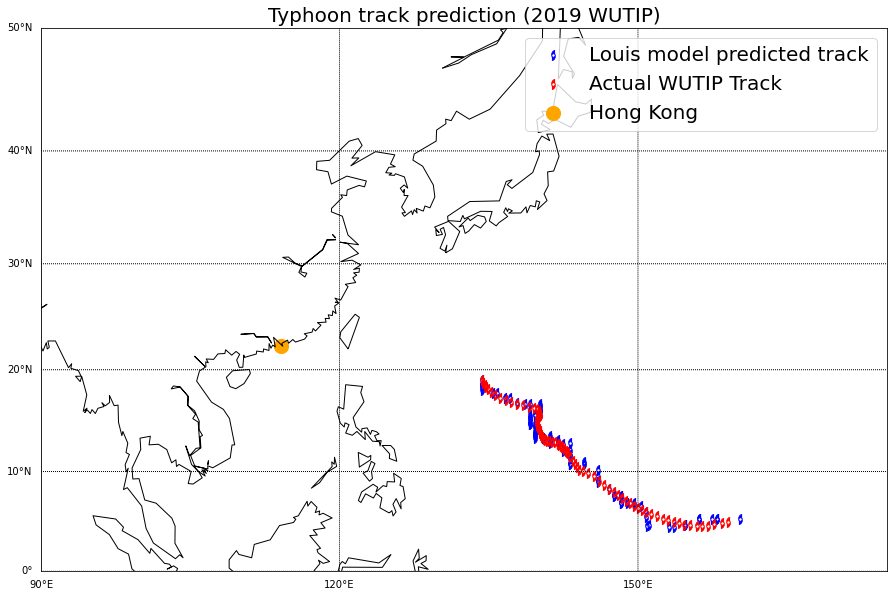

In [211]:
plt.figure(figsize=(20,10))
m = Basemap(projection='mill', llcrnrlat = 0, urcrnrlat = 50, llcrnrlon = 90, urcrnrlon =175, resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90,90,10), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180,180,30), labels=[0,0,0,1])

m.scatter(y_pred_long_WUTIP_formatted, y_pred_lat_WUTIP_formatted, latlon=True, s=100, c='blue', marker=hurricane, label = 'Louis model predicted track')
m.scatter(Y_original_2019_WUTIP_long, Y_original_WUTIP_lat, latlon=True, s=100, c='red', marker=hurricane, label = 'Actual WUTIP Track')
m.scatter(114.1694, 22.3193,latlon=True, s=200, c='orange', marker='o', label = 'Hong Kong')
plt.title('Typhoon track prediction (2019 WUTIP)' , fontsize=20)
plt.legend(prop={'size': 20})
plt.savefig("Classification 2019_WUTIP.png")
plt.show()